# MGMTMSA 408 -- Lecture 7: Multiarmed Bandits (Bernoulli Model)

In this notebook, we will test out several different policies for making actions in a multiarmed bandit model. We will consider a Bernoulli bandit model, where the reward $X_t$ at time $t$, given that we have taken action $a$, is the random variable
$$ X_t \sim \text{Bernoulli}(p_a)$$
where $p_a$ is the probability parameter of action $a$. Recall that a $\text{Bernoulli}(p)$ random variable is 1 with probability $p$ and 0 with probability $1 - p$. 

The setup that we are looking at is we have a website, and we have three candidate website designs (like the in-slide example with Prof. Misic's website). For each random visitor, we seek to decide which design to display, so that we maximize the long-run number of users who "convert" (i.e., download Prof. Misic's latest paper). 

In the example below, we are assuming that $X_t$ is a 1 if the $t$th website visitor converts, and 0 otherwise. If we assume this, then 
$$ X_1 + X_2 + \dots + X_t$$
is the total number of visitors who convert, out of $t$ total visitors; and 
$$ \frac{1}{t} ( X_1 + \dots + X_t ) $$
is the fraction of visitors out of $t$ total visitors who convert. 

Recall that $\hat{\mu}_k(t)$ are defined as 
$$ \hat{\mu}_k(t) = \frac{ Y_k(t) }{N_k(t)},$$
which is the current estimate of the mean reward from design $k$. We can think of $\hat{\mu}_k(t)$ as the estimated conversion rate of design $k$; it is a sample-based estimate of $p_k$ which is the _true_ conversion rate of design $k$.

Let's begin by setting up some variables and functions that we will use throughout our exploration of the different policies.

In [4]:
import pandas as pd

dataset = pd.read_csv('ucla_dataset.csv')

# Change arm column to replace arm_1 with 0 and arm_2 with 1 and arm_3 with 2
dataset['arm'] = dataset['arm'].replace('arm_1', 0)
dataset['arm'] = dataset['arm'].replace('arm_2', 1)
dataset['arm'] = dataset['arm'].replace('arm_3', 2)

# Train, test, validation split
train = dataset.sample(frac=0.8, random_state=0)
test = dataset.drop(train.index)
validation = train.sample(frac=0.2, random_state=0)                                                                                                                                                                                                                      

dataset

user_id        date  arm  click
0          1  2024-06-30    2      1
1          2  2024-06-30    2      0
2          3  2024-06-30    1      0
3          4  2024-06-30    1      1
4          5  2024-06-30    1      0
..       ...         ...  ...    ...
298      299  2024-06-30    2      0
299      300  2024-06-30    0      1
300      301  2024-06-30    2      0
301      302  2024-06-30    0      0
302      303  2024-06-30    1      0

[303 rows x 4 columns]

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Assume that we have 2000 visitors to our website.
T = 2000

# Assume that there are 3 different website designs. 
# To be able to simulate the different policies, we will
# specify what the conversion rate of each design is,
# through the array p.
# (The algorithms that we will see will not use p in any 
# way to select which design to display.)
K = 3
p = np.array([0.7, 0.8, 0.9])

# Lastly, define the function generate_reward() which
# draws a Bernoulli random variable according to the parameter
# of design a. 
def generate_reward(a):
    return int( np.random.rand() < p[a])

## Method 1: Greedy policy

In the greedy policy, we will display each of the three designs once. Then, we will display the design whose current value of $\hat{\mu}_a(t)$ (its estimated conversion rate) is highest. 

In [3]:
# Define the greedy policy function, which takes t (the current period) and Y and N (both arrays)
# as inputs.
def policy_greedy(t, Y, N):
    if (t < K):
        return t
    else: 
        muhat = Y / N
        a = np.argmax(muhat)
        return a 

# Now run the simulation:
np.random.seed(200)
nSims = 1000
cumulative_reward = np.zeros( (nSims, T) ) # Save the total reward in each simulation at each period.
action_history = np.zeros( (nSims, T)) # Save the action taken in each simulation in each period.
for s in range(nSims):
    Y = np.zeros(K)
    N = np.zeros(K)
    for t in range(T):
        a = policy_greedy(t, Y, N)
        reward = generate_reward(a)
        Y[a] += reward
        N[a] += 1
        cumulative_reward[s,t] = sum(Y)
        action_history[s,t] = a


action_history_greedy = action_history.copy()
mean_cumulative_reward_greedy = cumulative_reward.mean(axis = 0)
print("Cumulative reward at t = T (greedy): ",mean_cumulative_reward_greedy[-1])
print("Average per-period reward (greedy): ", mean_cumulative_reward_greedy[-1] / T)

Cumulative reward at t = T (greedy):  1723.124
Average per-period reward (greedy):  0.861562


In [ ]:
################################# UCLA Dataset #################################
# We have 303 visitors to our website.
T = len(dataset)

# There are 3 different website designs. 
K = dataset['arm'].nunique()

# Define the greedy policy function, which takes t (the current period) and Y and N (both arrays)
# as inputs.
def policy_greedy(t, Y, N):
    if (t < K):
        return t
    else: 
        muhat = Y / N
        a = np.argmax(muhat)
        return a 

# Now run the simulation:
np.random.seed(200)
nSims = 1000
cumulative_reward = np.zeros((nSims, T)) # Save the total reward in each simulation at each period.
action_history = np.zeros((nSims, T)) # Save the action taken in each simulation in each period.
for s in range(nSims):
    Y = np.zeros(K)
    N = np.zeros(K)
    for t in range(T):
        a = policy_greedy(t, Y, N)
        reward = generate_reward(a)
        Y[a] += reward
        N[a] += 1
        cumulative_reward[s,t] = sum(Y)
        action_history[s,t] = a


action_history_greedy = action_history.copy()
mean_cumulative_reward_greedy = cumulative_reward.mean(axis = 0)
print("Cumulative reward at t = T (greedy): ", mean_cumulative_reward_greedy[-1])
print("Average per-period reward (greedy): ", mean_cumulative_reward_greedy[-1] / T)

So what we find is:
- The mean cumulative reward by time $T$ is 1724.124. This means that over our 1000 simulations, this policy results in an average of 1723.124 conversions in total.
- The average per-period reward is 0.861562. This means that our effective/average conversion rate is 0.86. 

To understand how the policy behaves, it is also helpful to plot for each design, the probability of that design being selected over time. (Here, this probability is calculated by computing the relative frequency of $a = 0, 1, 2$ being selected at each $t$, over all 1000 simulations.)

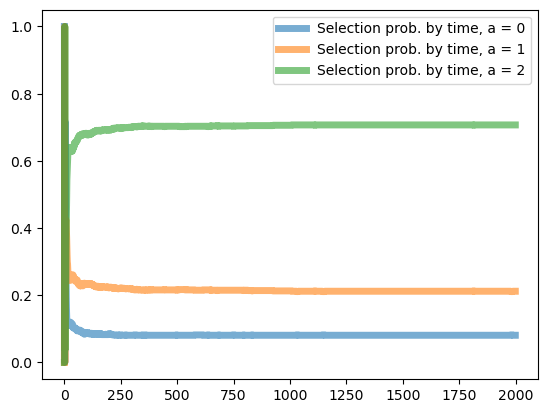

In [4]:
# Plot the empirical probability of each design being selected. 
for a in range(K):
    action_history_eq_a = action_history_greedy == a 
    a_prob_by_time = action_history_eq_a.mean(axis = 0)
    plt.plot(range(T), a_prob_by_time, '-', lw=5, alpha=0.6, label='Selection prob. by time, a = ' + str(a))
plt.legend()

From the above, notice that the probability of $a = 2$ being selected stabilizes at roughly 0.7, while the probabilities of $a = 1$ and $a = 0$ stabilize at 0.2 and under 0.1. This means that in the long run, we are only selecting the optimal design $a = 2$ about 70\% of the time; 30\% of the time we are selecting the suboptimal designs $a = 1$ and $a = 0$. 

This occurs because the greedy policy only pays attention to the sample mean of the reward of each action, and does not take into account any uncertainty in these values. As a result, what can happen is that early on, the sample mean for the best design $a = 2$ ends up being lower than its true expected value of 0.9, and so we favor the suboptimal designs ($a = 1$ or $a = 0$). As we display either of those designs, their sample means converge to their true conversion rates, while the sample mean of the optimal design remains below those values, and thus we never display the optimal design. 

## Method #2: Explore-then-commit policy

The second approach that we will look at is the explore-then-commit (ETC) policy. In the ETC policy, we first display each design several times -- in the cell below, we display each design 10 times -- and from that point forward, whichever design has the highest estimate of its average reward, we only display that design.

In [5]:
# Define the greedy policy function, which takes t (the current period) and nSuccesses and nPlays (both arrays)
# as inputs.
exploration_horizon = K * 10
def policy_ETC(t, Y, N):
    if (t < exploration_horizon):
        return t % K
    else: 
        muhat = Y / N
        a = np.argmax(muhat)
        return a 

# Now run the simulation:
np.random.seed(200)
nSims = 1000
cumulative_reward = np.zeros( (nSims, T) ) # Save the total reward in each simulation at each period.
action_history = np.zeros( (nSims, T)) # Save the action taken in each simulation in each period.
for s in range(nSims):
    Y = np.zeros(K)
    N = np.zeros(K)
    for t in range(T):
        a = policy_ETC(t, Y, N)
        reward = generate_reward(a)
        
        # Note: after exploration_horizon is reached, we stop updating Y and N, 
        # so that best action remains frozen. 
        if (t < exploration_horizon):
            Y[a] += reward
            N[a] += 1
        
        if (t == 0):
            cumulative_reward[s,t] = reward
        else:
            cumulative_reward[s,t] = cumulative_reward[s,t-1] + reward
        action_history[s,t] = a


action_history_ETC = action_history.copy()
mean_cumulative_reward_ETC = cumulative_reward.mean(axis = 0)
print("Cumulative reward at t = T (ETC): ",mean_cumulative_reward_ETC[-1])
print("Average per-period reward (ETC): ", mean_cumulative_reward_ETC[-1] / T)

Cumulative reward at t = T (ETC):  1678.4
Average per-period reward (ETC):  0.8392000000000001


This policy does not do as well as greedy; we only get a cumulative reward of 1678.4, and an average per-period reward of 0.839. The reason for this is that for the greedy policy, the estimates of the mean rewards of each action may still be updated over time, whereas for ETC, they effectively remain frozen after $mK$ periods. As a result, if the estimates $\mu_1(mK), \dots, \mu_K(mK)$ obtained after the $mK$ rounds of exploration deviate a lot from the true means $p_1,\dots,p_K$, then we risk committing to a suboptimal action. 

The cell below plots the selection probability by action; note that this probability remains fixed after $t = mK$, as we would expect. 

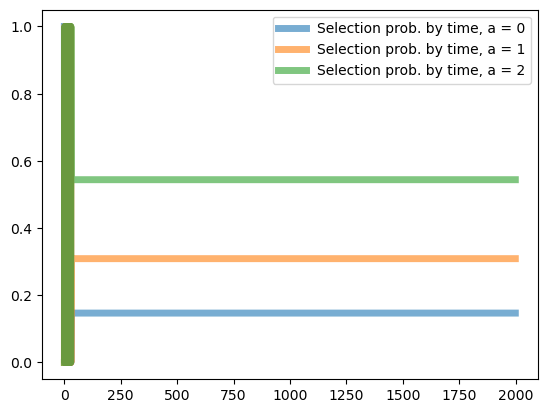

In [6]:
# Plot the empirical probability of each design being selected. 
for a in range(K):
    action_history_eq_a = action_history_ETC == a 
    a_prob_by_time = action_history_eq_a.mean(axis = 0)
    plt.plot(range(T), a_prob_by_time, '-', lw=5, alpha=0.6, label='Selection prob. by time, a = ' + str(a))
plt.legend()

## Method #3: Explore-then-greedy policy

The explore-then-greedy policy is a simple modification of the ETC policy, where after the initial exploration of the actions, we always take the action with the current best mean reward estimate. This allows for some updating to occur after exploration, and for the algorithm to correct for erroneous estimates of the mean reward from the exploration period.

In [7]:
# Define the explore-then-greedy policy function, which takes t (the current period) and nSuccesses and nPlays (both arrays)
# as inputs.
exploration_horizon = K * 10
def policy_ETG(t, Y, N):
    if (t < exploration_horizon):
        return t % K
    else: 
        muhat = Y / N
        a = np.argmax(muhat)
        return a 

# Now run the simulation:
np.random.seed(200)
nSims = 1000
cumulative_reward = np.zeros( (nSims, T) ) # Save the total reward in each simulation at each period.
action_history = np.zeros( (nSims, T)) # Save the action taken in each simulation in each period.
for s in range(nSims):
    Y = np.zeros(K)
    N = np.zeros(K)
    for t in range(T):
        a = policy_ETG(t, Y, N)
        reward = generate_reward(a)
        Y[a] += reward
        N[a] += 1
        cumulative_reward[s,t] = sum(Y)
        action_history[s,t] = a


action_history_ETG = action_history.copy()
mean_cumulative_reward_ETG = cumulative_reward.mean(axis = 0)
print("Cumulative reward at t = T (ETG): ",mean_cumulative_reward_ETG[-1])
print("Average per-period reward (ETG): ", mean_cumulative_reward_ETG[-1] / T)

Cumulative reward at t = T (ETG):  1771.515
Average per-period reward (ETG):  0.8857575000000001


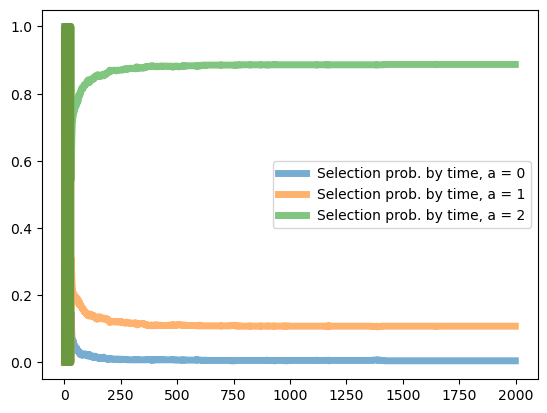

In [8]:
# Plot the empirical probability of each design being selected. 
for a in range(K):
    action_history_eq_a = action_history_ETG == a 
    a_prob_by_time = action_history_eq_a.mean(axis = 0)
    plt.plot(range(T), a_prob_by_time, '-', lw=5, alpha=0.6, label='Selection prob. by time, a = ' + str(a))
plt.legend()

## Method 4: $\epsilon$-greedy policy

As we saw above, one deficiency of the greedy policy is that it does not explore actions that currently appear to be suboptimal, but could be optimal. One simple way to rectify this is to force the policy to randomly choose an action. This is exemplified by the $\epsilon$-greedy policy, which works as follows:
- At each period:
     - With probability $\epsilon$, pick one of the $n$ actions to take uniformly at random.
     - With probability $1 - \epsilon$, pick the greedy action.
    
Thus, this policy will choose one of the actions at random, regardless of the current sample means, with probability $\epsilon$. (For example, if $\epsilon = 0.20$, then we will select one of the $n$ actions randomly about 20\% of the time.)

In [9]:
# Define the epsilon-greedy policy below. The parameter epsilon controls how frequently one does not
# follow the greedy action. As with the greedy policy, we will play each action once in the first 3 (= K)
# periods. 
epsilon = 0.20
def policy_epsilon_greedy(t, Y, N):
    if (t < K):
        return t
    else:
        if (np.random.rand() < epsilon):
            a = np.random.choice(range(K))
        else:
            muhat = Y / N
            a = np.argmax(muhat)
        return a 

# Run the simulation:
np.random.seed(200)
nSims = 1000
cumulative_reward = np.zeros( (nSims, T) )
action_history = np.zeros( (nSims, T))
for s in range(nSims):
    Y = np.zeros(K)
    N = np.zeros(K)
    for t in range(T):
        a = policy_epsilon_greedy(t, Y, N)
        reward = generate_reward(a)
        Y[a] += reward
        N[a] += 1
        cumulative_reward[s,t] = sum(Y)
        action_history[s,t] = a

action_history_epsilon_greedy = action_history.copy()
mean_cumulative_reward_epsilon_greedy = cumulative_reward.mean(axis = 0)
print("Cumulative reward at t = T (epsilon-greedy): ", mean_cumulative_reward_epsilon_greedy[-1])
print("Average per-period reward (epsilon-greedy): ", mean_cumulative_reward_epsilon_greedy[-1] / T)

Cumulative reward at t = T (epsilon-greedy):  1753.96
Average per-period reward (epsilon-greedy):  0.87698


By following the $\epsilon$-greedy strategy, our cumulative reward (i.e., total number of conversions) is 1753.96, while the effective per-period conversion rate is 0.87698, both of which are better than the ordinary greedy policy. 

Let us again consider the frequency with which each design is being selected:

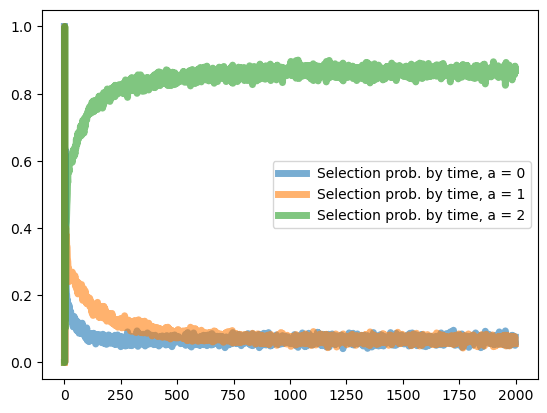

In [10]:
# Plot the empirical probability of each design being selected.
for a in range(K):
    action_history_eq_a = action_history_epsilon_greedy == a 
    a_prob_by_time = action_history_eq_a.mean(axis = 0)
    plt.plot(range(T), a_prob_by_time, '-', lw=5, alpha=0.6, label='Selection prob. by time, a = ' + str(a))
plt.legend()

We can see that while the selection probability of design $a = 2$ does get closer to 1 and the selection probabilities of $a = 1$ and $a = 0$ get closer to zero, they again appear to stabilize at constant values (just over 0.8 for $a = 2$). Ideally, we would want the probability of $a = 2$ to converge to 1, and the probabilities of $a = 0$ and $a = 1$ to converge to zero. 

The drawback of $\epsilon$-greedy is that exploration is done in a forced way. Ideally, as time goes on, we would like to attenuate how much exploration we do based on how precise our estimates of the $\hat{\mu}_k$'s are. 

## Thompson sampling, warmup 1: updating the posterior distribution of a Bernoulli random variable

The last policy that we will consider is Thompson sampling, which requires us to define a Bayesian prior of each action's success probability. The most common prior distribution used in practice is the Beta distribution. 

To visualize how the Beta distribution and the Beta-Bernoulli model work, the (interactive) code below simulates a sequence of Bernoulli random variables, and updates the posterior distribution of $p$ after each such random variable is observed. The resulting distribution is then plotted. You can exit the loop by typing `n` when prompted (all other input will lead to one more iteration in the loop). 

Try testing different values for `p_demo`. What is happening to the posterior distribution as you conduct more and more updates? 



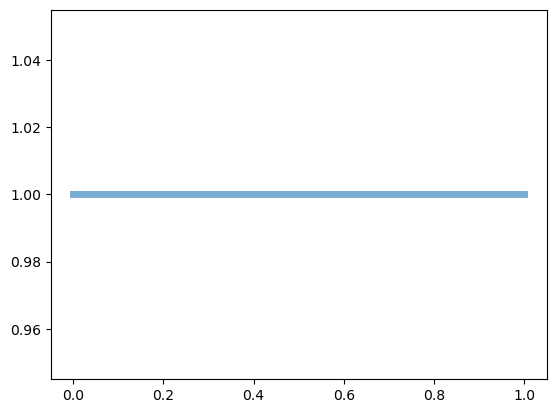

(Prior distribution)
t =  0 , reward: (none)
Y_demo =  0 , N_demo =  0
alpha=1, beta = 1
Continue? (y/n)


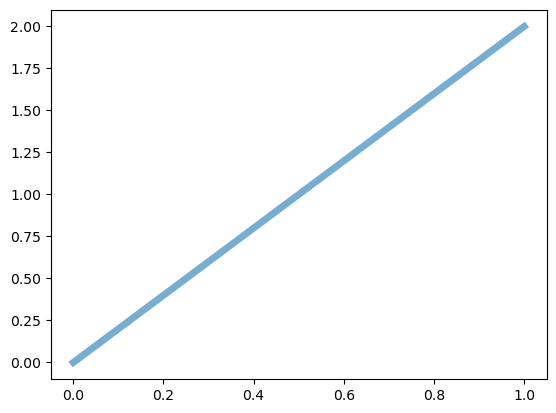

Posterior distribution after t =  1  updates
reward:  1
Y_demo =  1 , N_demo =  1
alpha=2, beta = 1
Continue? (y/n)


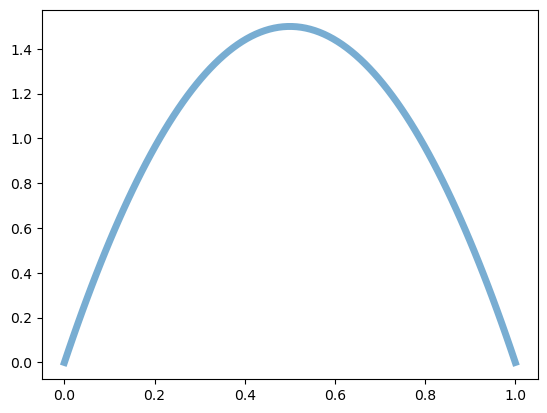

Posterior distribution after t =  2  updates
reward:  0
Y_demo =  1 , N_demo =  2
alpha=2, beta = 2
Continue? (y/n)


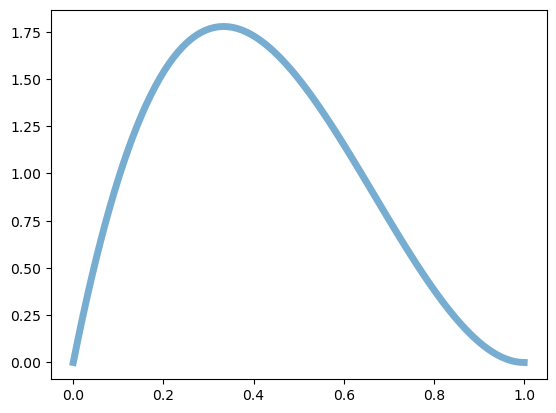

Posterior distribution after t =  3  updates
reward:  0
Y_demo =  1 , N_demo =  3
alpha=2, beta = 3
Continue? (y/n)


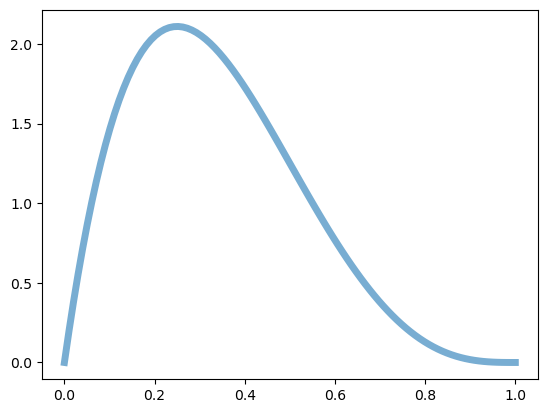

Posterior distribution after t =  4  updates
reward:  0
Y_demo =  1 , N_demo =  4
alpha=2, beta = 4
Continue? (y/n)


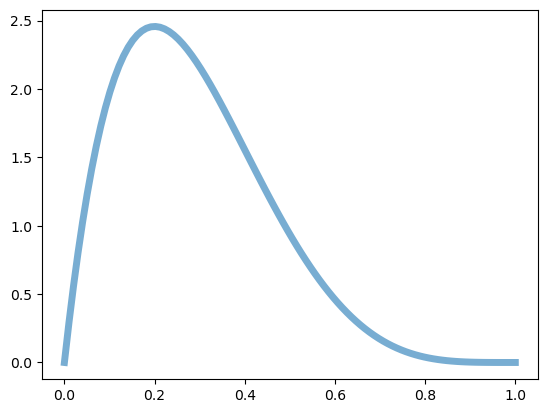

Posterior distribution after t =  5  updates
reward:  0
Y_demo =  1 , N_demo =  5
alpha=2, beta = 5
Continue? (y/n)


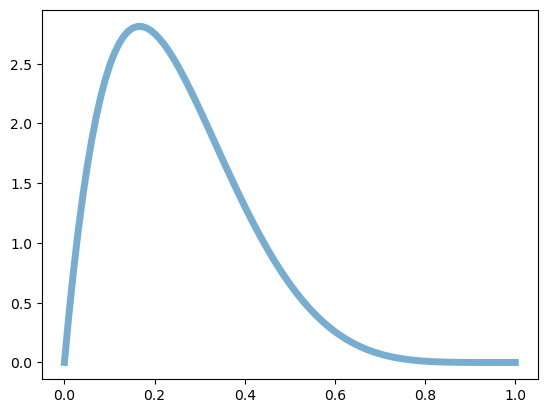

Posterior distribution after t =  6  updates
reward:  0
Y_demo =  1 , N_demo =  6
alpha=2, beta = 6
Continue? (y/n)


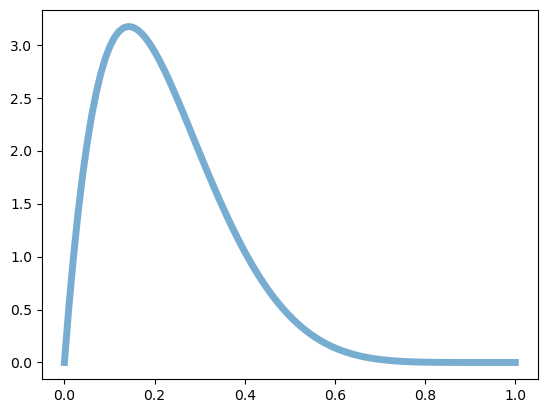

Posterior distribution after t =  7  updates
reward:  0
Y_demo =  1 , N_demo =  7
alpha=2, beta = 7
Continue? (y/n)


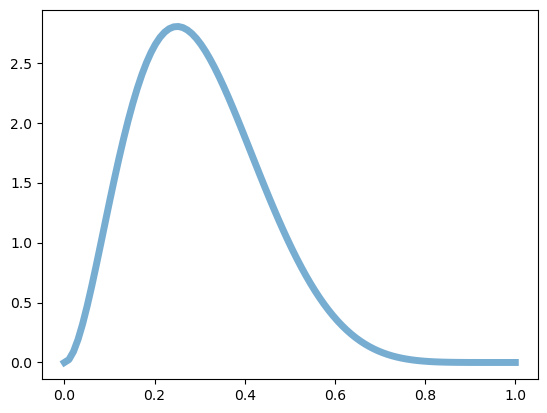

Posterior distribution after t =  8  updates
reward:  1
Y_demo =  2 , N_demo =  8
alpha=3, beta = 7
Continue? (y/n)


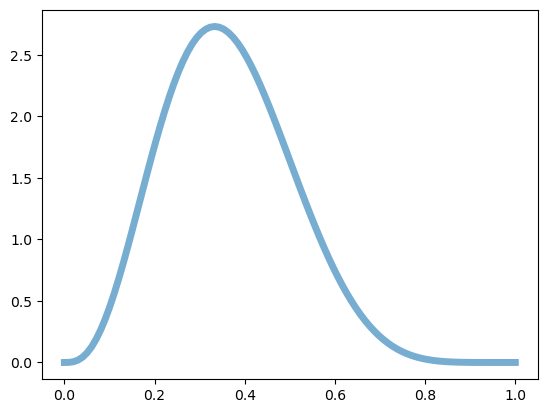

Posterior distribution after t =  9  updates
reward:  1
Y_demo =  3 , N_demo =  9
alpha=4, beta = 7
Continue? (y/n)


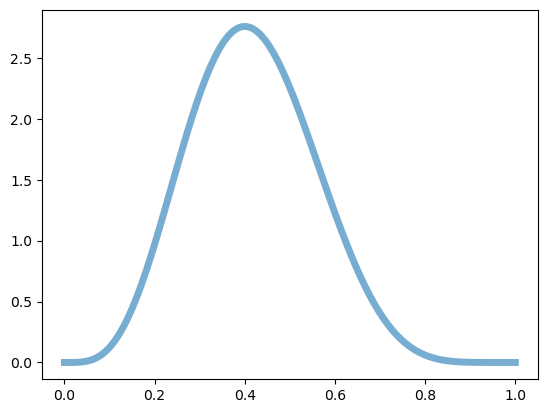

Posterior distribution after t =  10  updates
reward:  1
Y_demo =  4 , N_demo =  10
alpha=5, beta = 7
Continue? (y/n)


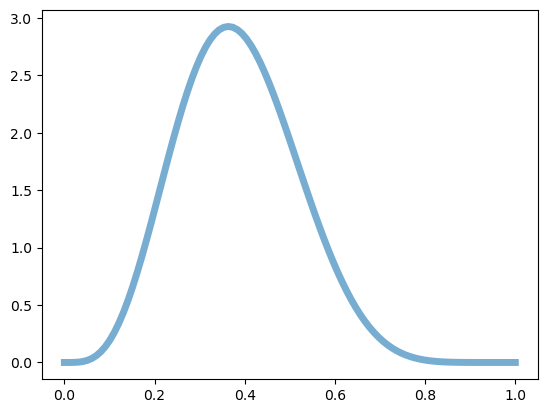

Posterior distribution after t =  11  updates
reward:  0
Y_demo =  4 , N_demo =  11
alpha=5, beta = 8
Continue? (y/n)


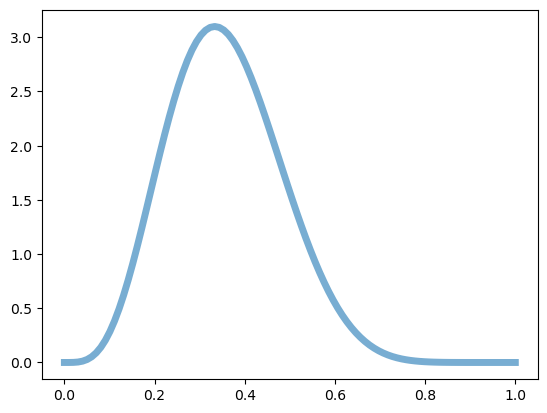

Posterior distribution after t =  12  updates
reward:  0
Y_demo =  4 , N_demo =  12
alpha=5, beta = 9
Continue? (y/n)


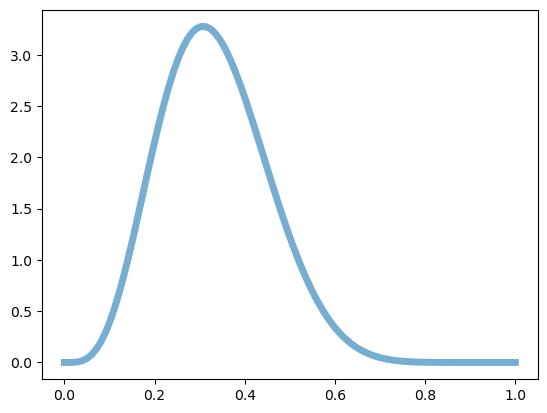

Posterior distribution after t =  13  updates
reward:  0
Y_demo =  4 , N_demo =  13
alpha=5, beta = 10
Continue? (y/n)


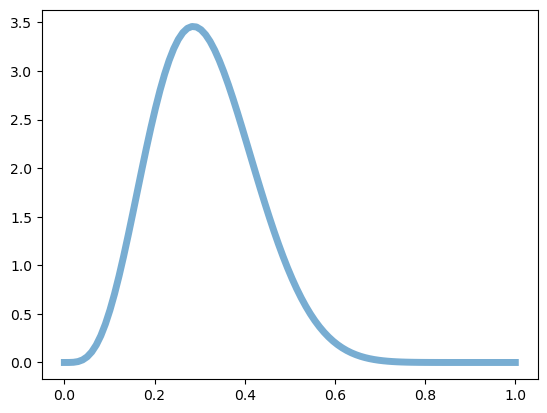

Posterior distribution after t =  14  updates
reward:  0
Y_demo =  4 , N_demo =  14
alpha=5, beta = 11
Continue? (y/n)


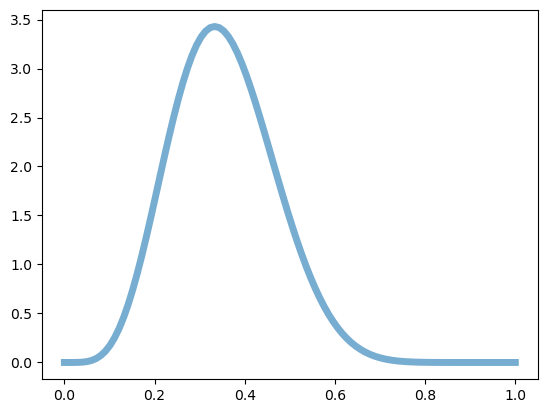

Posterior distribution after t =  15  updates
reward:  1
Y_demo =  5 , N_demo =  15
alpha=6, beta = 11
Continue? (y/n)


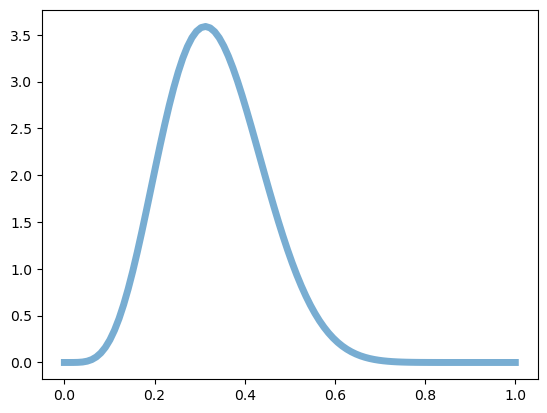

Posterior distribution after t =  16  updates
reward:  0
Y_demo =  5 , N_demo =  16
alpha=6, beta = 12
Continue? (y/n)


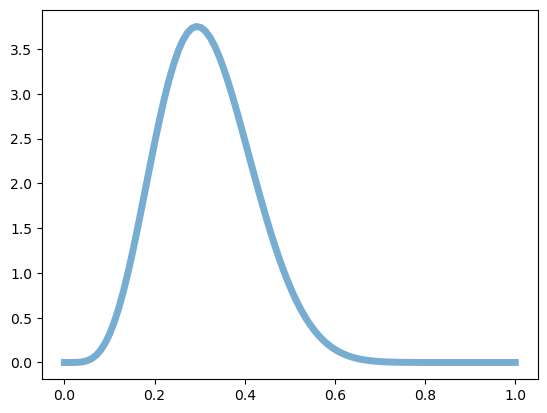

Posterior distribution after t =  17  updates
reward:  0
Y_demo =  5 , N_demo =  17
alpha=6, beta = 13
Continue? (y/n)


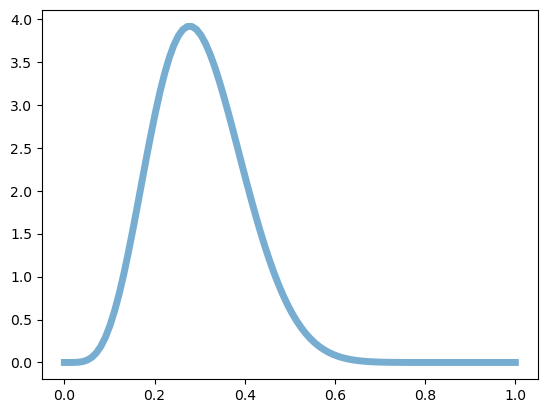

Posterior distribution after t =  18  updates
reward:  0
Y_demo =  5 , N_demo =  18
alpha=6, beta = 14
Continue? (y/n)


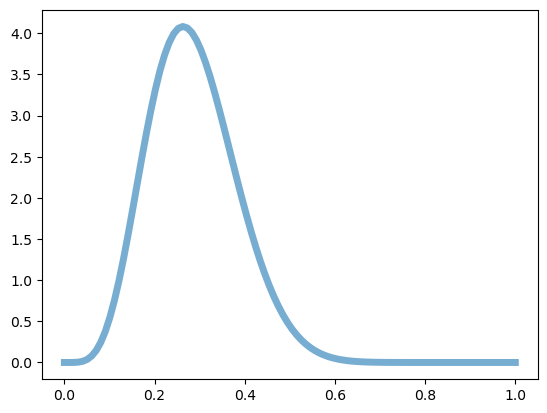

Posterior distribution after t =  19  updates
reward:  0
Y_demo =  5 , N_demo =  19
alpha=6, beta = 15
Continue? (y/n)


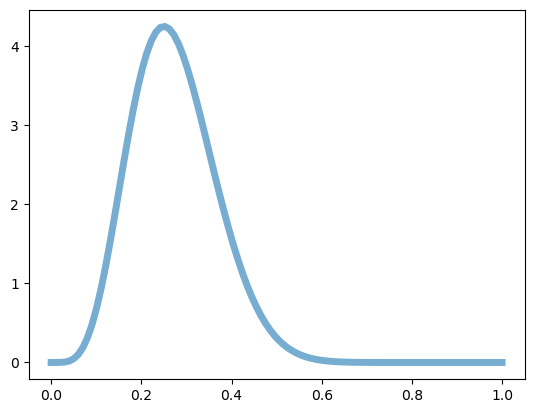

Posterior distribution after t =  20  updates
reward:  0
Y_demo =  5 , N_demo =  20
alpha=6, beta = 16
Continue? (y/n)


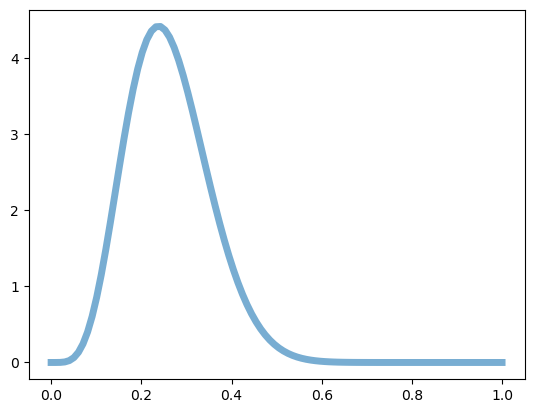

Posterior distribution after t =  21  updates
reward:  0
Y_demo =  5 , N_demo =  21
alpha=6, beta = 17
Continue? (y/n)


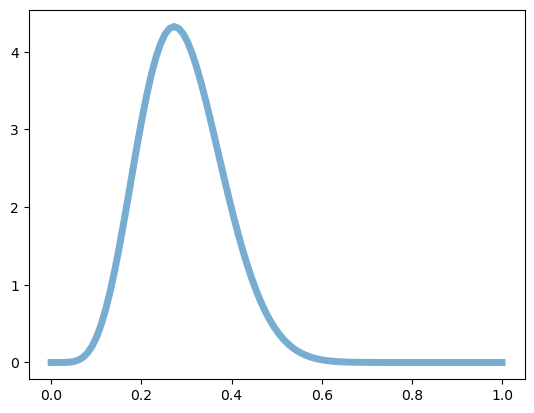

Posterior distribution after t =  22  updates
reward:  1
Y_demo =  6 , N_demo =  22
alpha=7, beta = 17
Continue? (y/n)


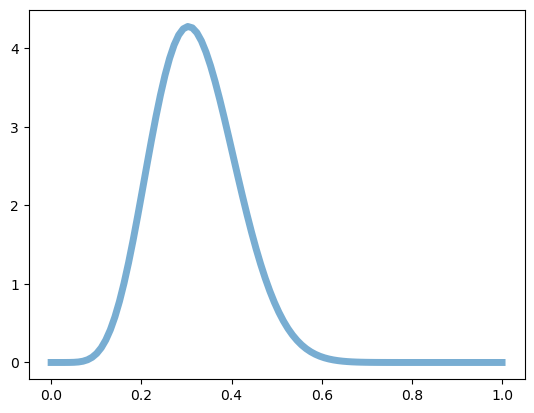

Posterior distribution after t =  23  updates
reward:  1
Y_demo =  7 , N_demo =  23
alpha=8, beta = 17
Continue? (y/n)


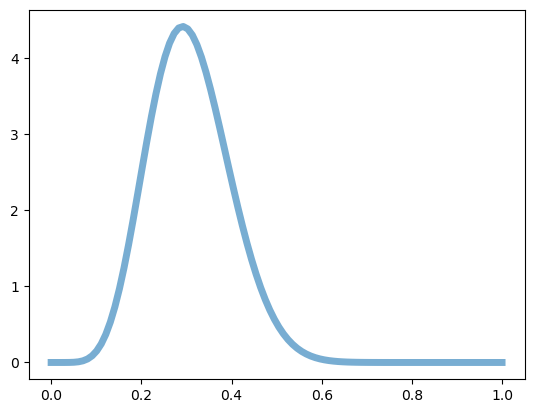

Posterior distribution after t =  24  updates
reward:  0
Y_demo =  7 , N_demo =  24
alpha=8, beta = 18
Continue? (y/n)


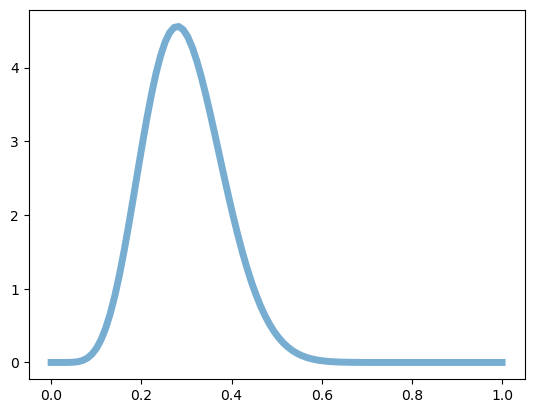

Posterior distribution after t =  25  updates
reward:  0
Y_demo =  7 , N_demo =  25
alpha=8, beta = 19
Continue? (y/n)


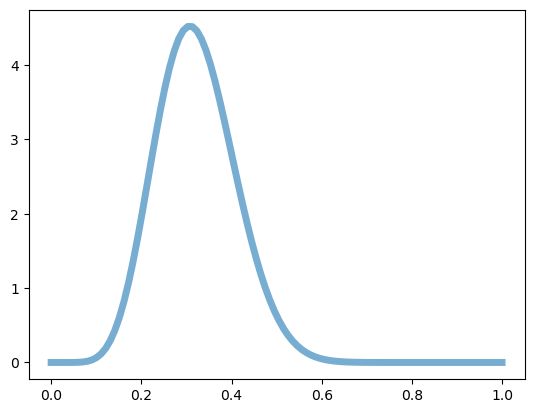

Posterior distribution after t =  26  updates
reward:  1
Y_demo =  8 , N_demo =  26
alpha=9, beta = 19
Continue? (y/n)


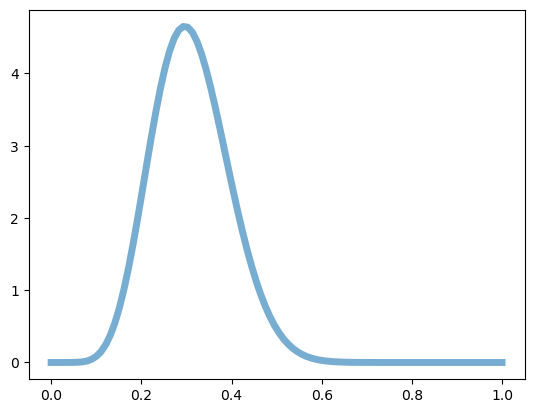

Posterior distribution after t =  27  updates
reward:  0
Y_demo =  8 , N_demo =  27
alpha=9, beta = 20
Continue? (y/n)


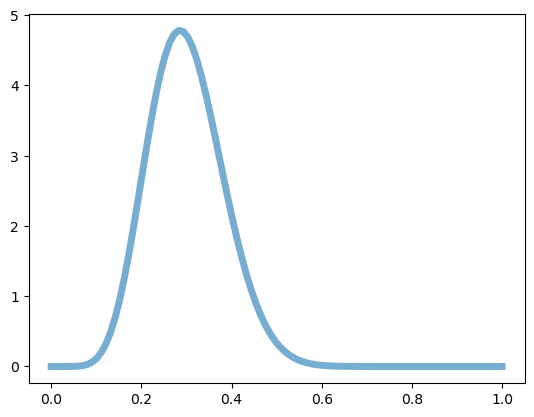

Posterior distribution after t =  28  updates
reward:  0
Y_demo =  8 , N_demo =  28
alpha=9, beta = 21
Continue? (y/n)


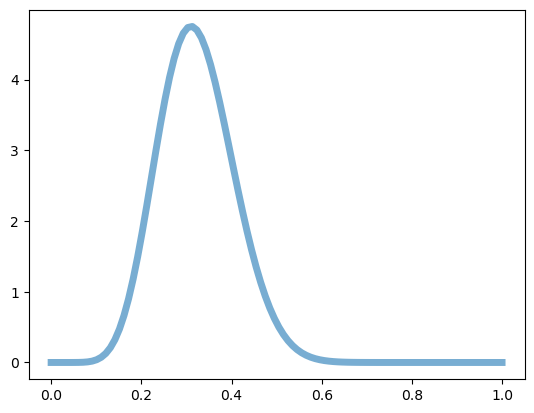

Posterior distribution after t =  29  updates
reward:  1
Y_demo =  9 , N_demo =  29
alpha=10, beta = 21
Continue? (y/n)


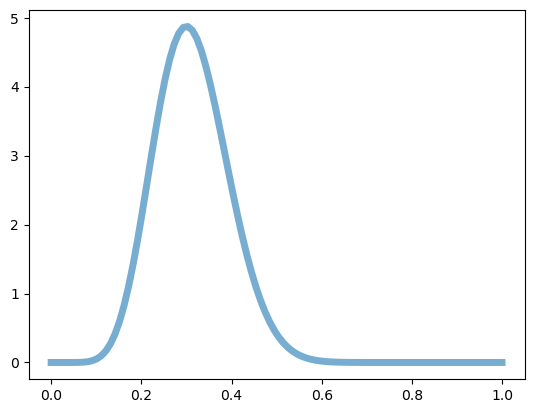

Posterior distribution after t =  30  updates
reward:  0
Y_demo =  9 , N_demo =  30
alpha=10, beta = 22
Continue? (y/n)


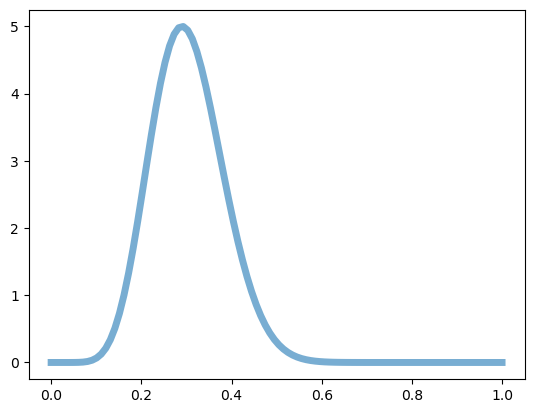

Posterior distribution after t =  31  updates
reward:  0
Y_demo =  9 , N_demo =  31
alpha=10, beta = 23
Continue? (y/n)


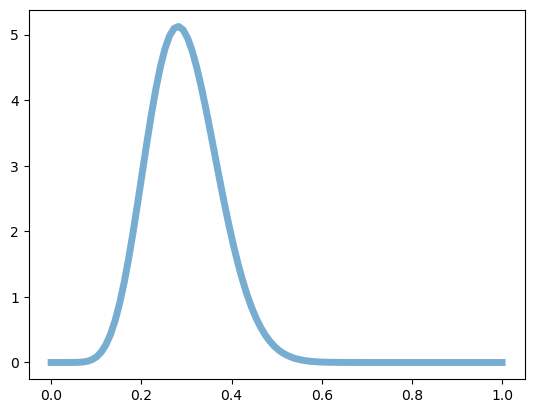

Posterior distribution after t =  32  updates
reward:  0
Y_demo =  9 , N_demo =  32
alpha=10, beta = 24
Continue? (y/n)


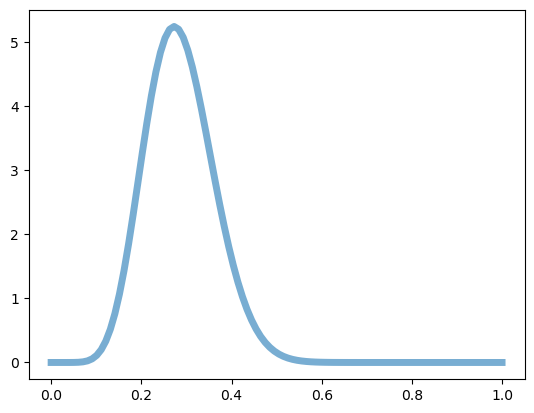

Posterior distribution after t =  33  updates
reward:  0
Y_demo =  9 , N_demo =  33
alpha=10, beta = 25
Continue? (y/n)


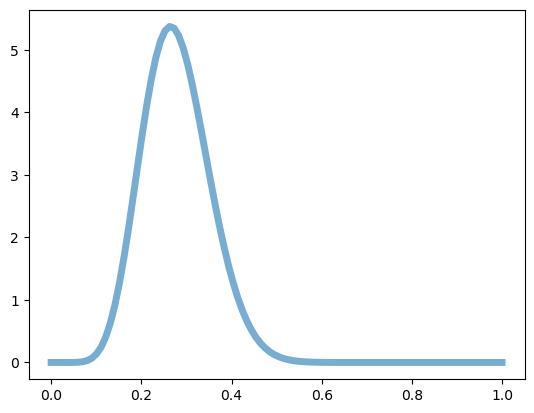

Posterior distribution after t =  34  updates
reward:  0
Y_demo =  9 , N_demo =  34
alpha=10, beta = 26
Continue? (y/n)


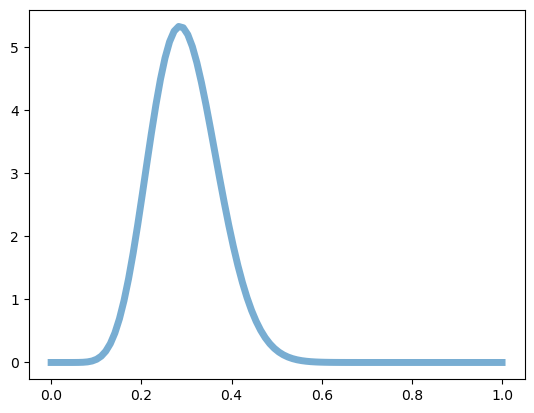

Posterior distribution after t =  35  updates
reward:  1
Y_demo =  10 , N_demo =  35
alpha=11, beta = 26
Continue? (y/n)


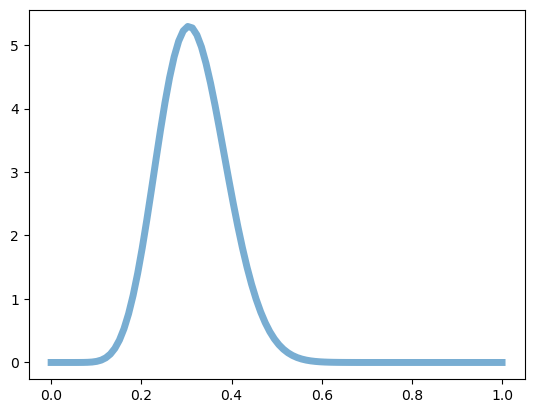

Posterior distribution after t =  36  updates
reward:  1
Y_demo =  11 , N_demo =  36
alpha=12, beta = 26
Continue? (y/n)


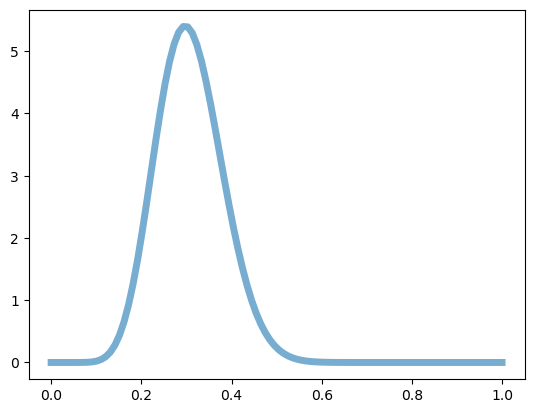

Posterior distribution after t =  37  updates
reward:  0
Y_demo =  11 , N_demo =  37
alpha=12, beta = 27
Continue? (y/n)


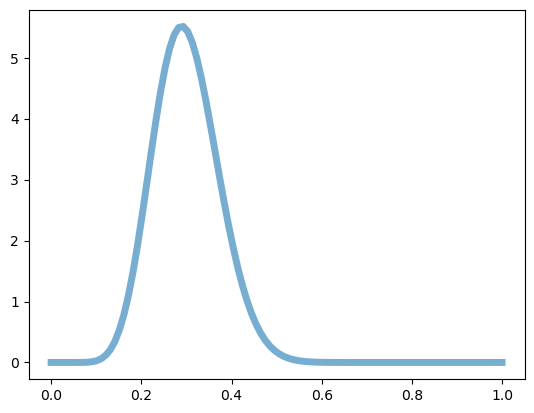

Posterior distribution after t =  38  updates
reward:  0
Y_demo =  11 , N_demo =  38
alpha=12, beta = 28
Continue? (y/n)


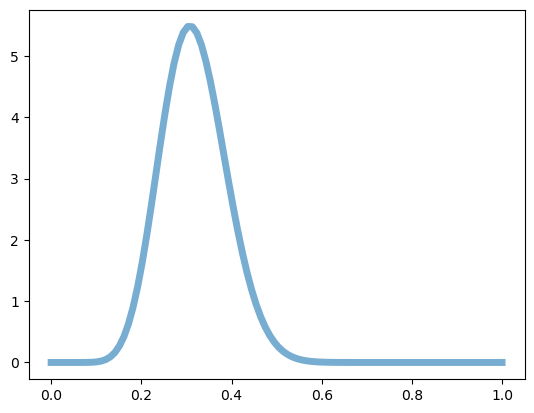

Posterior distribution after t =  39  updates
reward:  1
Y_demo =  12 , N_demo =  39
alpha=13, beta = 28
Continue? (y/n)


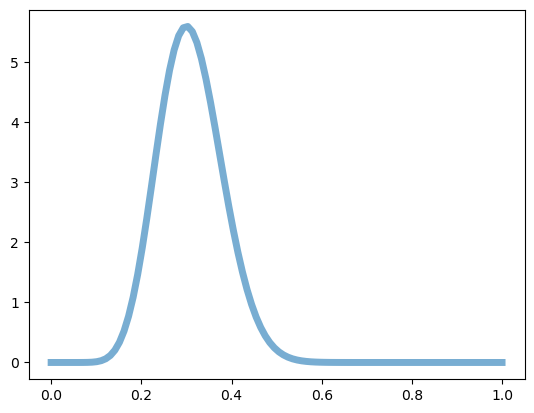

Posterior distribution after t =  40  updates
reward:  0
Y_demo =  12 , N_demo =  40
alpha=13, beta = 29
Continue? (y/n)


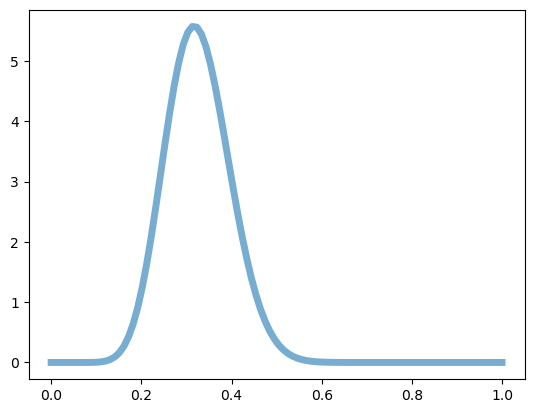

Posterior distribution after t =  41  updates
reward:  1
Y_demo =  13 , N_demo =  41
alpha=14, beta = 29
Continue? (y/n)


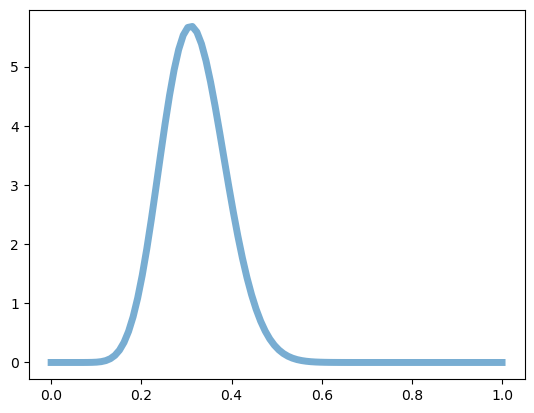

Posterior distribution after t =  42  updates
reward:  0
Y_demo =  13 , N_demo =  42
alpha=14, beta = 30
Continue? (y/n)


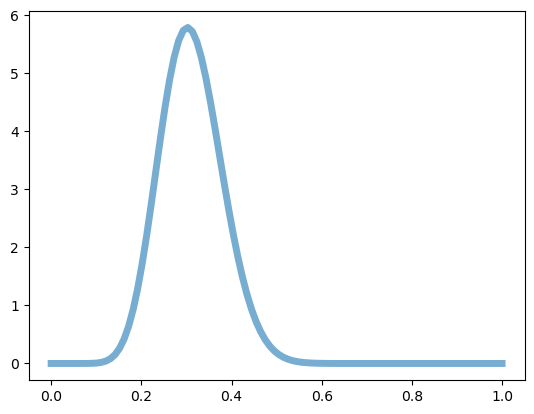

Posterior distribution after t =  43  updates
reward:  0
Y_demo =  13 , N_demo =  43
alpha=14, beta = 31
Continue? (y/n)


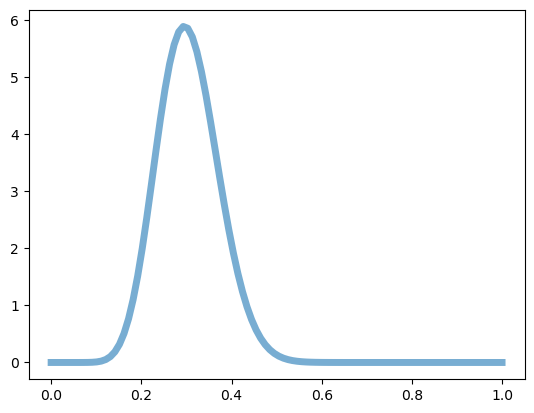

Posterior distribution after t =  44  updates
reward:  0
Y_demo =  13 , N_demo =  44
alpha=14, beta = 32
Continue? (y/n)


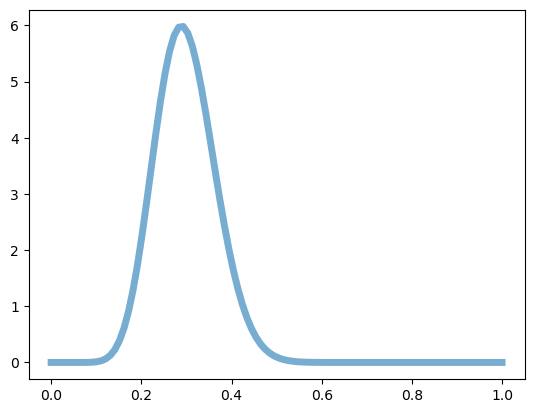

Posterior distribution after t =  45  updates
reward:  0
Y_demo =  13 , N_demo =  45
alpha=14, beta = 33
Continue? (y/n)


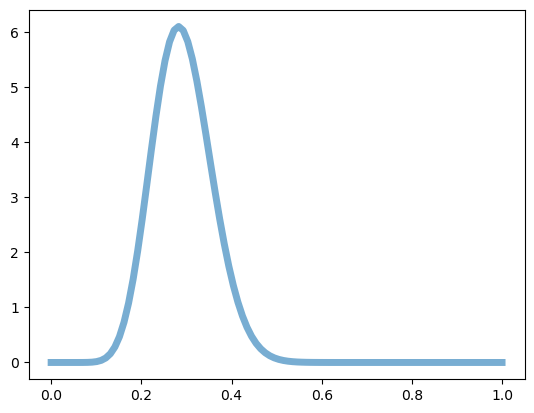

Posterior distribution after t =  46  updates
reward:  0
Y_demo =  13 , N_demo =  46
alpha=14, beta = 34
Continue? (y/n)


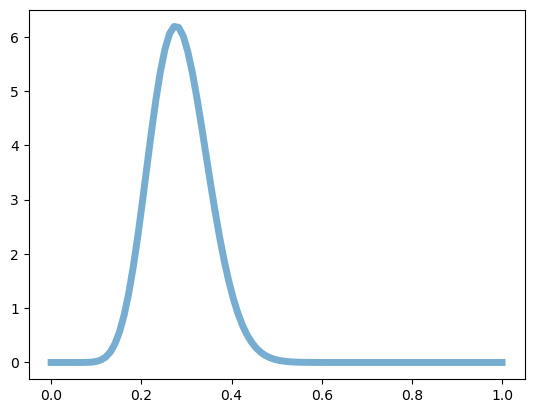

Posterior distribution after t =  47  updates
reward:  0
Y_demo =  13 , N_demo =  47
alpha=14, beta = 35
Continue? (y/n)


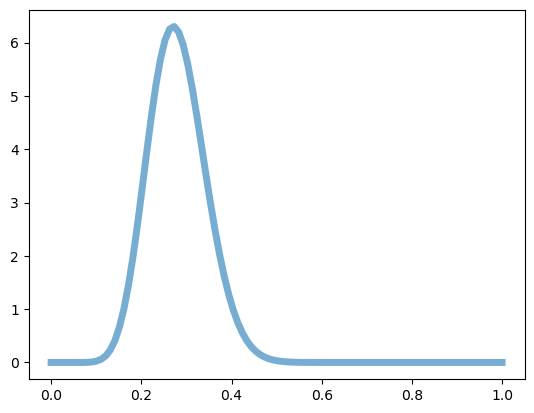

Posterior distribution after t =  48  updates
reward:  0
Y_demo =  13 , N_demo =  48
alpha=14, beta = 36
Continue? (y/n)


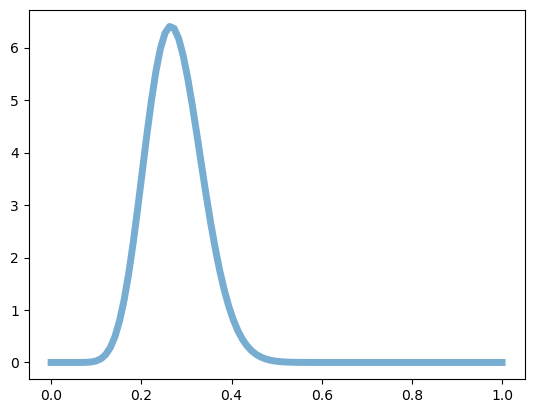

Posterior distribution after t =  49  updates
reward:  0
Y_demo =  13 , N_demo =  49
alpha=14, beta = 37
Continue? (y/n)


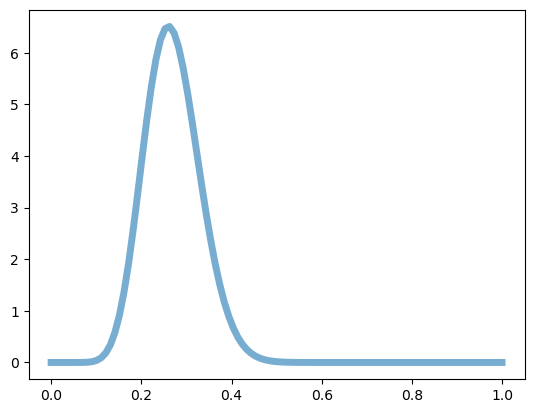

Posterior distribution after t =  50  updates
reward:  0
Y_demo =  13 , N_demo =  50
alpha=14, beta = 38
Continue? (y/n)


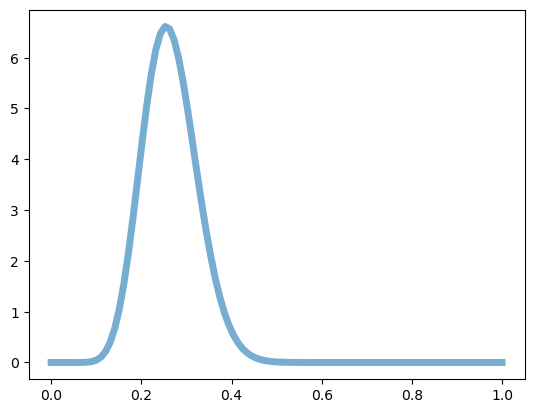

Posterior distribution after t =  51  updates
reward:  0
Y_demo =  13 , N_demo =  51
alpha=14, beta = 39
Continue? (y/n)


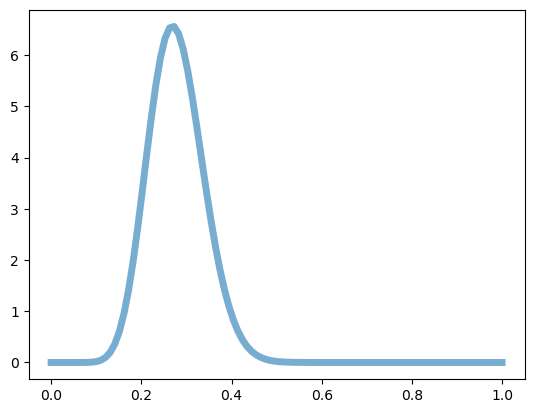

Posterior distribution after t =  52  updates
reward:  1
Y_demo =  14 , N_demo =  52
alpha=15, beta = 39
Continue? (y/n)


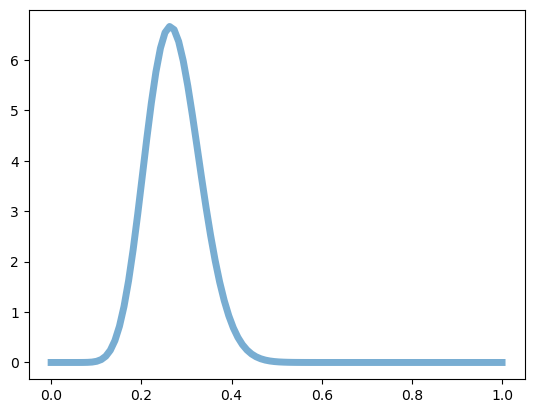

Posterior distribution after t =  53  updates
reward:  0
Y_demo =  14 , N_demo =  53
alpha=15, beta = 40
Continue? (y/n)


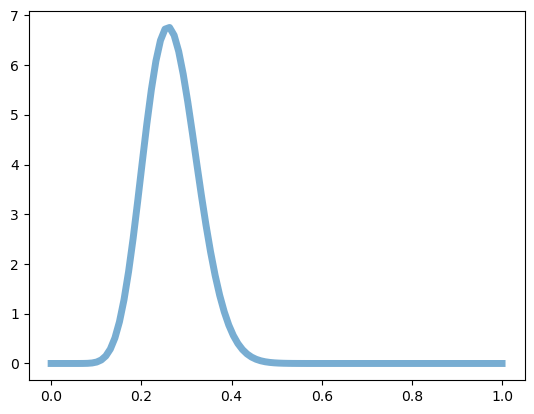

Posterior distribution after t =  54  updates
reward:  0
Y_demo =  14 , N_demo =  54
alpha=15, beta = 41
Continue? (y/n)


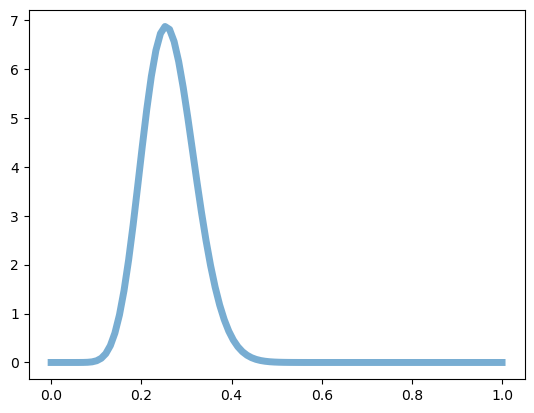

Posterior distribution after t =  55  updates
reward:  0
Y_demo =  14 , N_demo =  55
alpha=15, beta = 42
Continue? (y/n)


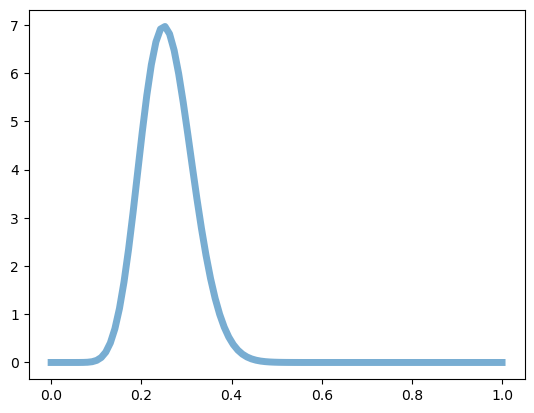

Posterior distribution after t =  56  updates
reward:  0
Y_demo =  14 , N_demo =  56
alpha=15, beta = 43
Continue? (y/n)


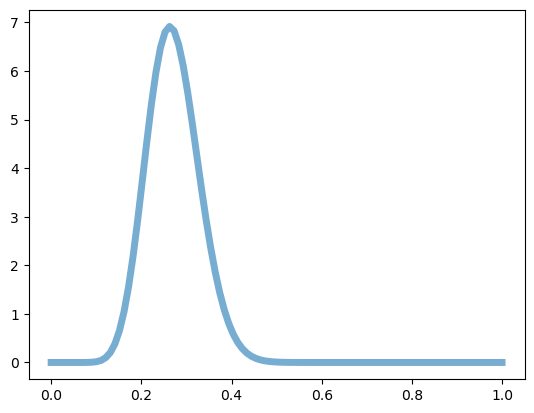

Posterior distribution after t =  57  updates
reward:  1
Y_demo =  15 , N_demo =  57
alpha=16, beta = 43
Continue? (y/n)


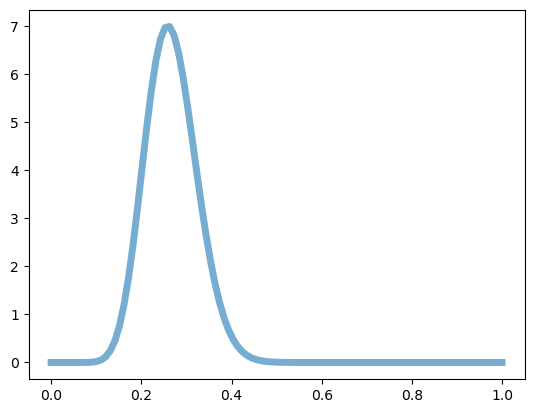

Posterior distribution after t =  58  updates
reward:  0
Y_demo =  15 , N_demo =  58
alpha=16, beta = 44
Continue? (y/n)


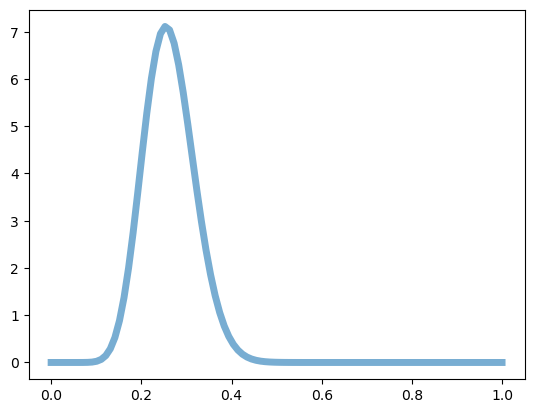

Posterior distribution after t =  59  updates
reward:  0
Y_demo =  15 , N_demo =  59
alpha=16, beta = 45
Continue? (y/n)


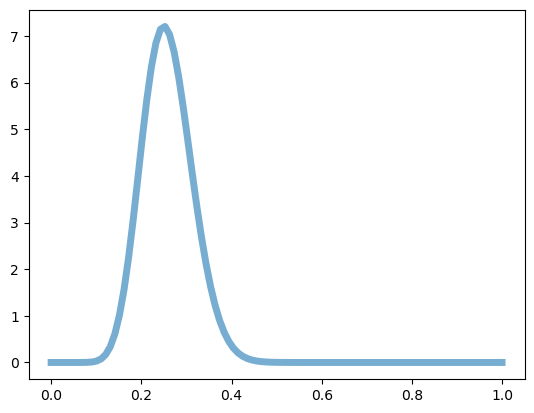

Posterior distribution after t =  60  updates
reward:  0
Y_demo =  15 , N_demo =  60
alpha=16, beta = 46
Continue? (y/n)


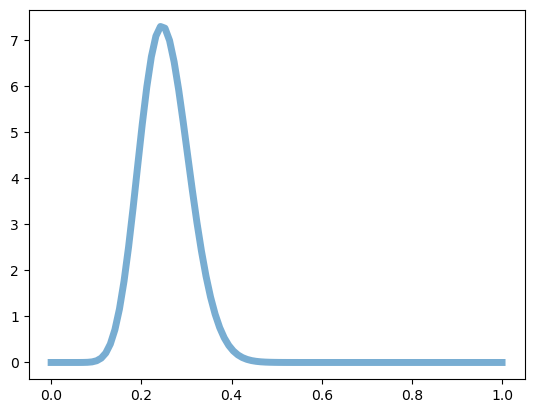

Posterior distribution after t =  61  updates
reward:  0
Y_demo =  15 , N_demo =  61
alpha=16, beta = 47
Continue? (y/n)


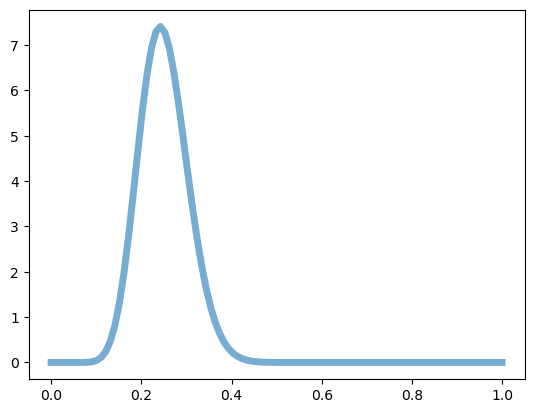

Posterior distribution after t =  62  updates
reward:  0
Y_demo =  15 , N_demo =  62
alpha=16, beta = 48
Continue? (y/n)


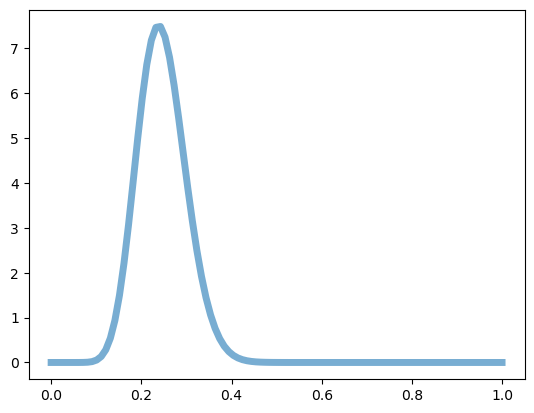

Posterior distribution after t =  63  updates
reward:  0
Y_demo =  15 , N_demo =  63
alpha=16, beta = 49
Continue? (y/n)


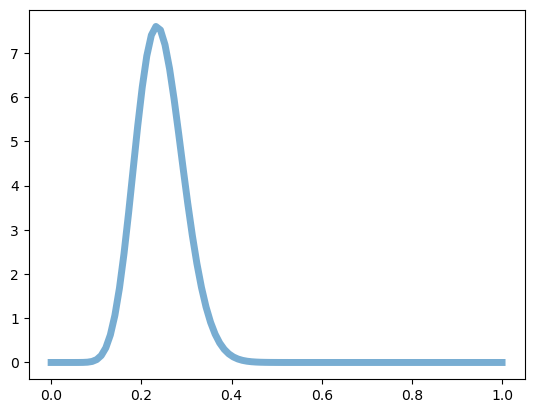

Posterior distribution after t =  64  updates
reward:  0
Y_demo =  15 , N_demo =  64
alpha=16, beta = 50
Continue? (y/n)


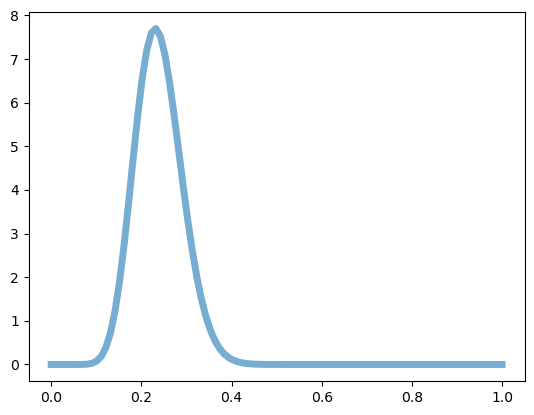

Posterior distribution after t =  65  updates
reward:  0
Y_demo =  15 , N_demo =  65
alpha=16, beta = 51
Continue? (y/n)


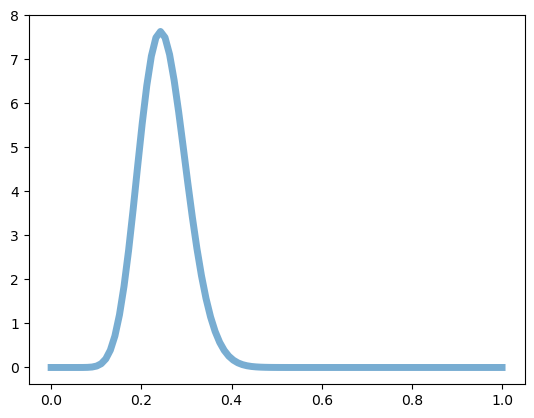

Posterior distribution after t =  66  updates
reward:  1
Y_demo =  16 , N_demo =  66
alpha=17, beta = 51
Continue? (y/n)


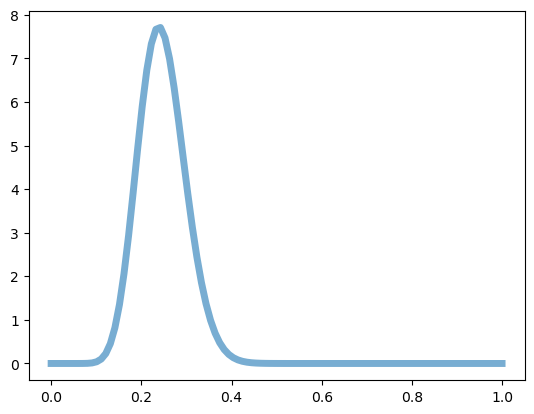

Posterior distribution after t =  67  updates
reward:  0
Y_demo =  16 , N_demo =  67
alpha=17, beta = 52
Continue? (y/n)


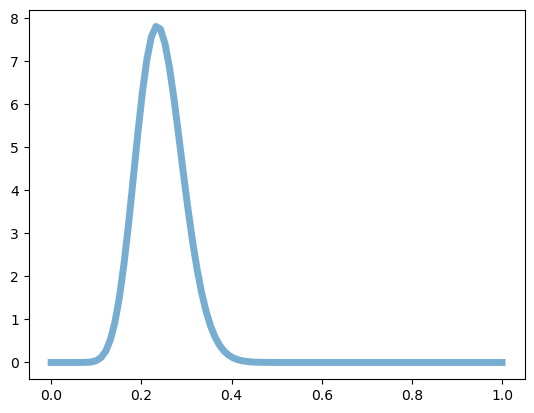

Posterior distribution after t =  68  updates
reward:  0
Y_demo =  16 , N_demo =  68
alpha=17, beta = 53
Continue? (y/n)


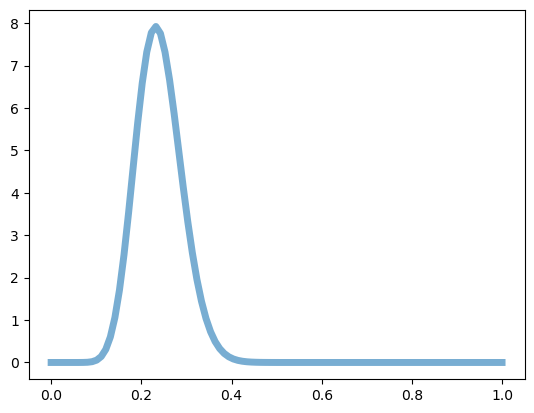

Posterior distribution after t =  69  updates
reward:  0
Y_demo =  16 , N_demo =  69
alpha=17, beta = 54
Continue? (y/n)


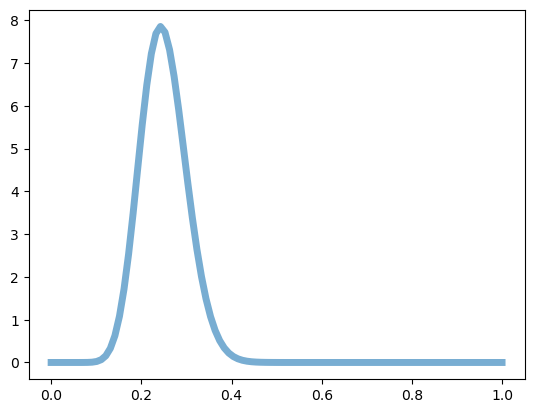

Posterior distribution after t =  70  updates
reward:  1
Y_demo =  17 , N_demo =  70
alpha=18, beta = 54
Continue? (y/n)


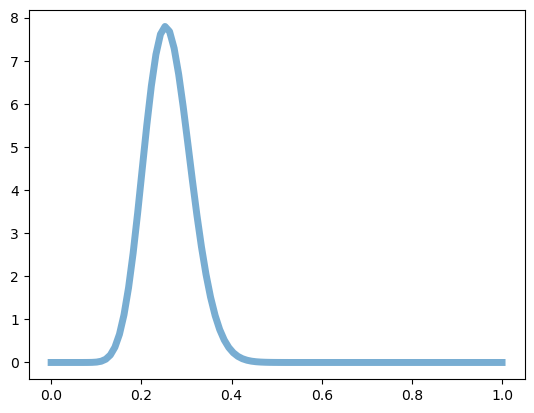

Posterior distribution after t =  71  updates
reward:  1
Y_demo =  18 , N_demo =  71
alpha=19, beta = 54
Continue? (y/n)


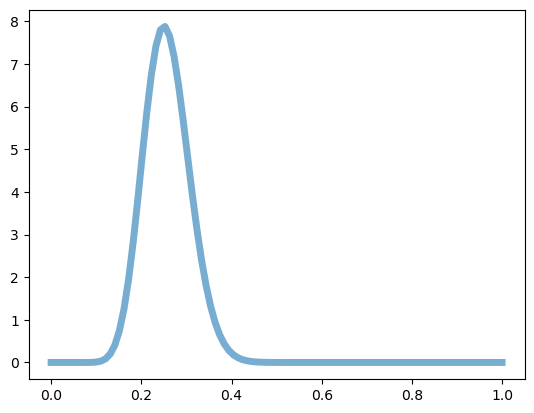

Posterior distribution after t =  72  updates
reward:  0
Y_demo =  18 , N_demo =  72
alpha=19, beta = 55
Continue? (y/n)


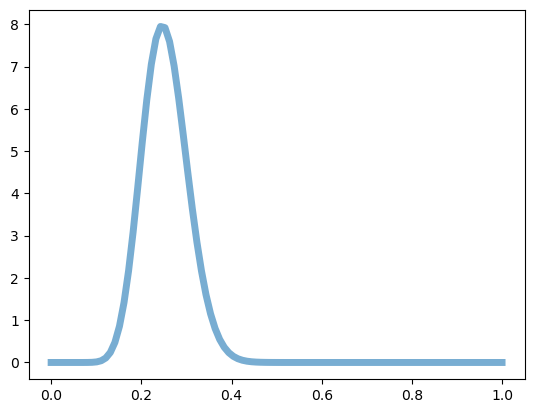

Posterior distribution after t =  73  updates
reward:  0
Y_demo =  18 , N_demo =  73
alpha=19, beta = 56
Continue? (y/n)


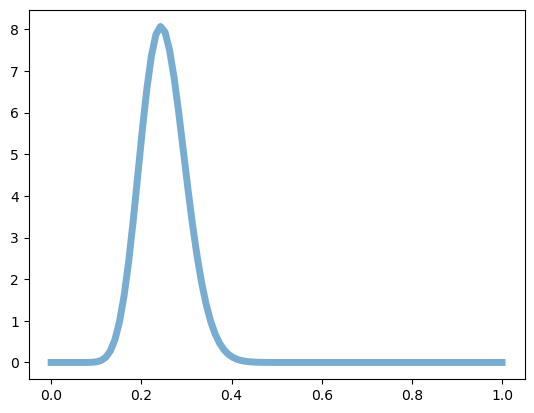

Posterior distribution after t =  74  updates
reward:  0
Y_demo =  18 , N_demo =  74
alpha=19, beta = 57
Continue? (y/n)


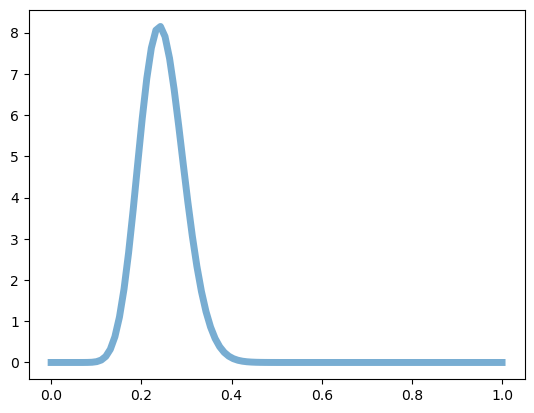

Posterior distribution after t =  75  updates
reward:  0
Y_demo =  18 , N_demo =  75
alpha=19, beta = 58
Continue? (y/n)


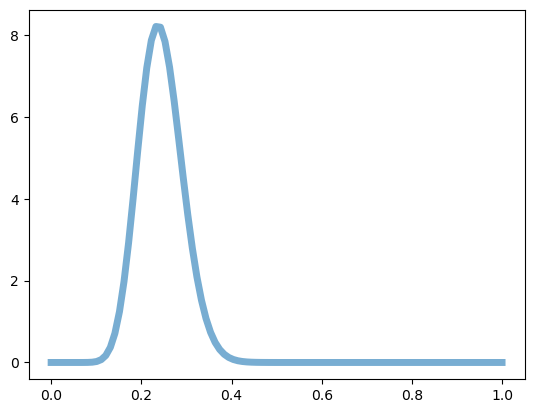

Posterior distribution after t =  76  updates
reward:  0
Y_demo =  18 , N_demo =  76
alpha=19, beta = 59
Continue? (y/n)


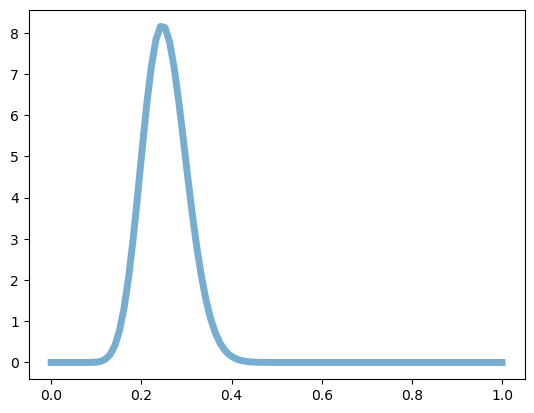

Posterior distribution after t =  77  updates
reward:  1
Y_demo =  19 , N_demo =  77
alpha=20, beta = 59
Continue? (y/n)


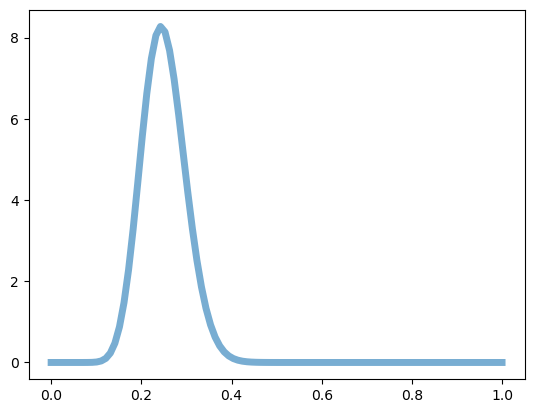

Posterior distribution after t =  78  updates
reward:  0
Y_demo =  19 , N_demo =  78
alpha=20, beta = 60
Continue? (y/n)


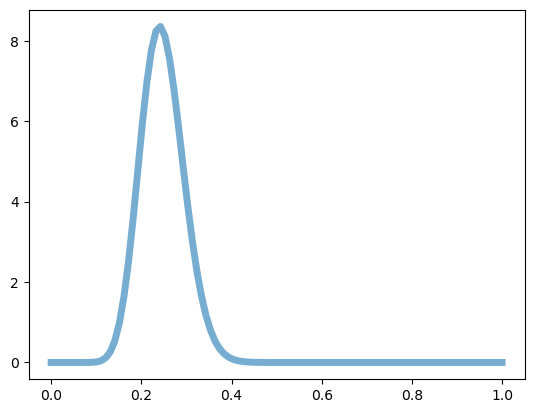

Posterior distribution after t =  79  updates
reward:  0
Y_demo =  19 , N_demo =  79
alpha=20, beta = 61
Continue? (y/n)


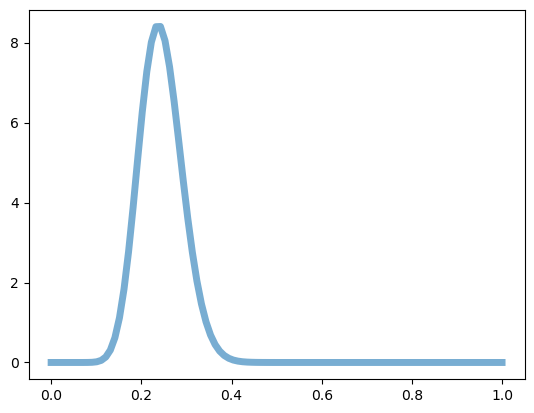

Posterior distribution after t =  80  updates
reward:  0
Y_demo =  19 , N_demo =  80
alpha=20, beta = 62
Continue? (y/n)


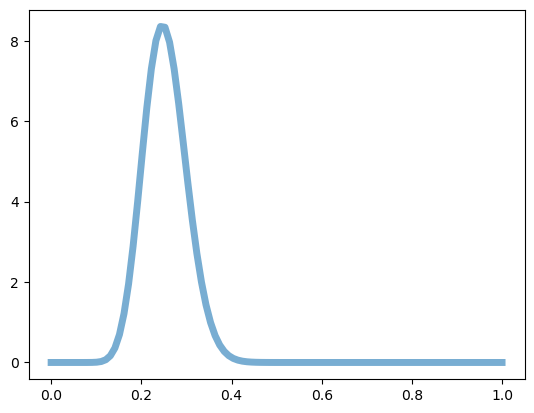

Posterior distribution after t =  81  updates
reward:  1
Y_demo =  20 , N_demo =  81
alpha=21, beta = 62
Continue? (y/n)


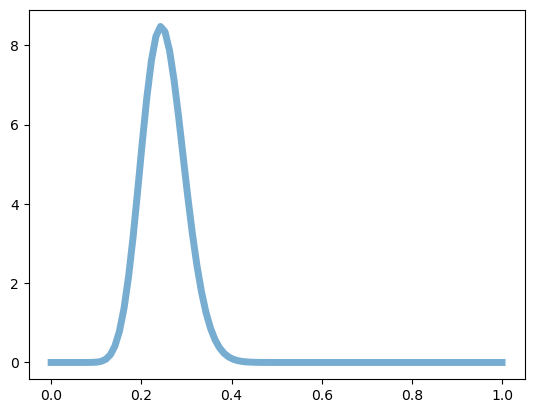

Posterior distribution after t =  82  updates
reward:  0
Y_demo =  20 , N_demo =  82
alpha=21, beta = 63
Continue? (y/n)


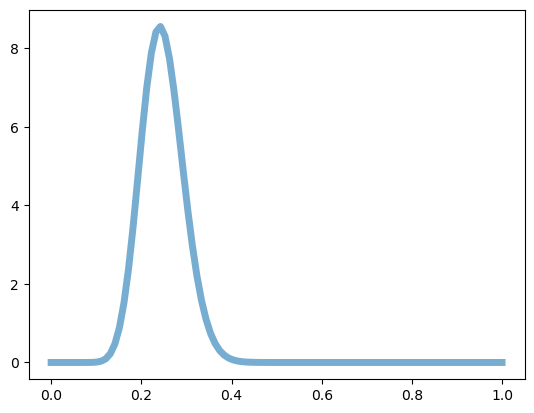

Posterior distribution after t =  83  updates
reward:  0
Y_demo =  20 , N_demo =  83
alpha=21, beta = 64
Continue? (y/n)


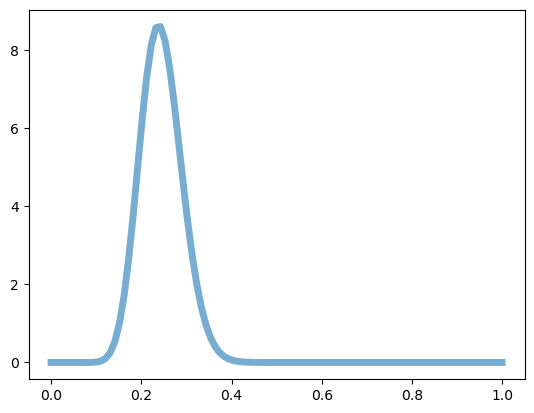

Posterior distribution after t =  84  updates
reward:  0
Y_demo =  20 , N_demo =  84
alpha=21, beta = 65
Continue? (y/n)n


In [11]:
import scipy.stats as stats 

p_demo = 0.2 # This is the true value of the Bernoulli parameter.
Y_demo = 0 # How many successes have been observed (i.e., how many times was X = 1)?
N_demo = 0 # How many Bernoulli random variables were simulated? 

t = 0

# Initialize the beta distribution parameters. 
# At the beginning, alpha and beta are both just 1. 
alpha = 1 # + Y_demo
beta = 1 # + N_demo - Y_demo 

# These next commands plot the current Beta distribution, which is 
# our prior distribution on p.
x = np.linspace(0,1,100)
pdf = stats.beta.pdf(x, alpha,beta)
plt.plot(x, pdf, '-', lw=5, alpha=0.6, label='Prior distribution')
plt.ion()
plt.show()
plt.pause(0.001)
print("(Prior distribution)")
print("t = ", t, ", reward: (none)")
print("Y_demo = ", Y_demo, ", N_demo = ", N_demo)
print('alpha='+str(alpha)+', beta = '+str(beta))
continue_string = input("Continue? (y/n)")


while (True):
    t += 1
    reward = int(np.random.rand() < p_demo)
    Y_demo += reward
    N_demo += 1

    alpha = 1 + Y_demo
    beta = 1 + N_demo - Y_demo 

    x = np.linspace(0,1,100)
    pdf = stats.beta.pdf(x, alpha,beta)


    plt.plot(x, pdf, '-', lw=5, alpha=0.6, label='Posterior distribution')
    plt.ion()
    plt.show()
    plt.pause(0.001)
    print("Posterior distribution after t = ", t, 
          " updates")
    print("reward: ", reward)
    print("Y_demo = ", Y_demo, ", N_demo = ", N_demo)
    print('alpha='+str(alpha)+', beta = '+str(beta))
    continue_string = input("Continue? (y/n)")
    if (continue_string == "n"):
        break



## Warmup 2 before Thompson sampling: visualizing how the posterior distributions change with each iteration of Thompson sampling

The cell below now takes the above code a step further, where we actually simulate Thompson sampling and observe how the posterior distributions change. What do you notice about the posterior distributions of the three actions ($p_1 = 0.7$, $p_2 = 0.8$, $p_3 = 0.9$) over time? 

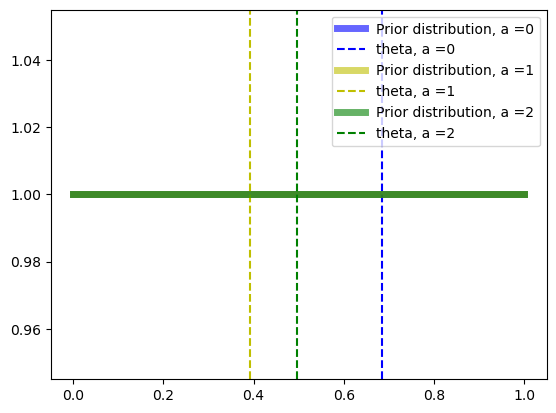

(Prior distributions)
t =  0
Y =  [0. 0. 0.] , N =  [0. 0. 0.]
alpha=[1. 1. 1.], beta = [1. 1. 1.]
theta = [0.68439475 0.3919491  0.4962598 ]
a =  0
Reward from this a = 1
['b', 'y', 'g']


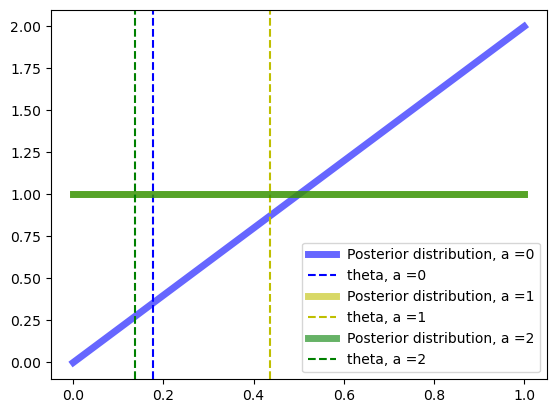

Posterior distribution after t =  1  updates
Y =  [1. 0. 0.] , N =  [1. 0. 0.]
alpha=[2. 1. 1.], beta = [1. 1. 1.]
theta = [0.17603368 0.43537774 0.13777086]
a =  1
Reward from this a = 1
['b', 'y', 'g']


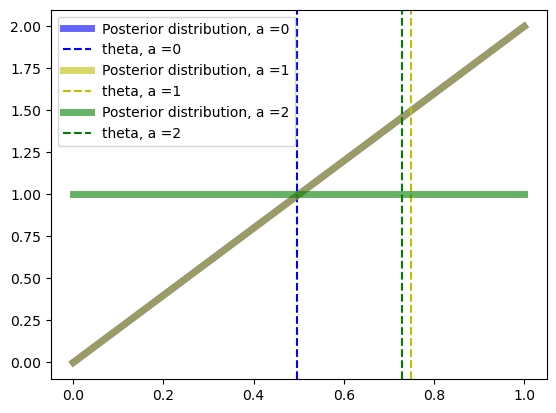

Posterior distribution after t =  2  updates
Y =  [1. 1. 0.] , N =  [1. 1. 0.]
alpha=[2. 2. 1.], beta = [1. 1. 1.]
theta = [0.49539605 0.74950311 0.72948568]
a =  1
Reward from this a = 1
['b', 'y', 'g']


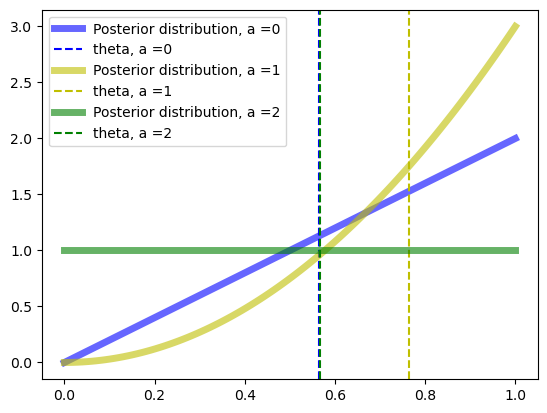

Posterior distribution after t =  3  updates
Y =  [1. 2. 0.] , N =  [1. 2. 0.]
alpha=[2. 3. 1.], beta = [1. 1. 1.]
theta = [0.56425809 0.76491045 0.56795776]
a =  1
Reward from this a = 1
['b', 'y', 'g']


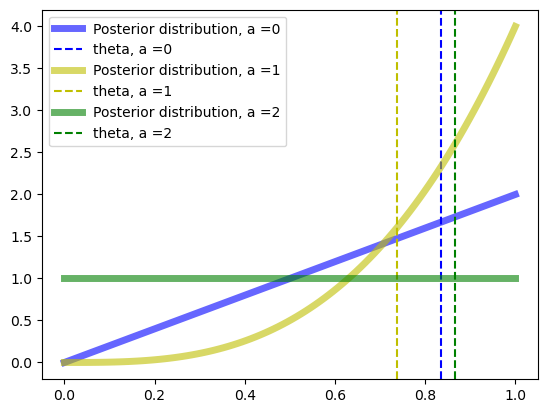

Posterior distribution after t =  4  updates
Y =  [1. 3. 0.] , N =  [1. 3. 0.]
alpha=[2. 4. 1.], beta = [1. 1. 1.]
theta = [0.83602674 0.73696328 0.86707893]
a =  2
Reward from this a = 1
['b', 'y', 'g']


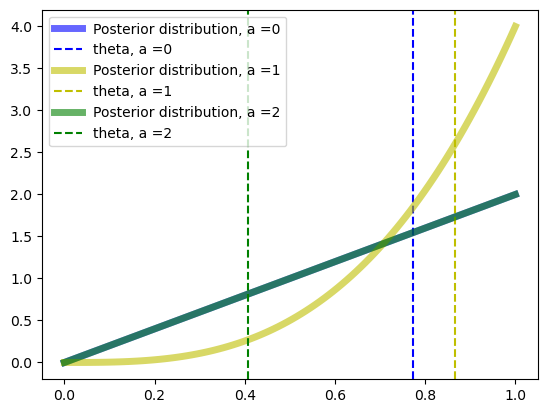

Posterior distribution after t =  5  updates
Y =  [1. 3. 1.] , N =  [1. 3. 1.]
alpha=[2. 4. 2.], beta = [1. 1. 1.]
theta = [0.77238991 0.86722012 0.40781406]
a =  1
Reward from this a = 1
['b', 'y', 'g']


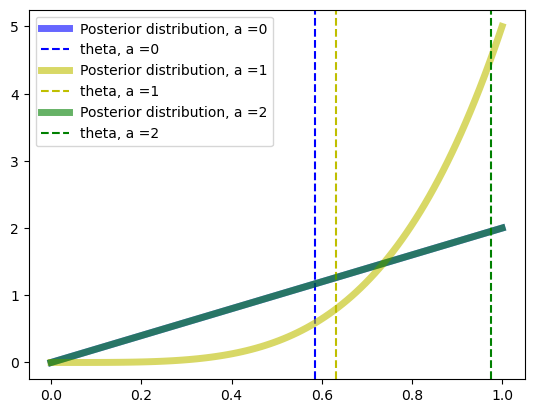

Posterior distribution after t =  6  updates
Y =  [1. 4. 1.] , N =  [1. 4. 1.]
alpha=[2. 5. 2.], beta = [1. 1. 1.]
theta = [0.58597839 0.63199611 0.97473412]
a =  2
Reward from this a = 1
['b', 'y', 'g']


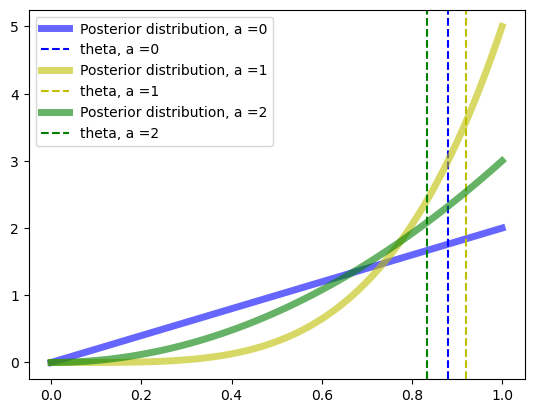

Posterior distribution after t =  7  updates
Y =  [1. 4. 2.] , N =  [1. 4. 2.]
alpha=[2. 5. 3.], beta = [1. 1. 1.]
theta = [0.88013429 0.92103895 0.83371144]
a =  1
Reward from this a = 1
['b', 'y', 'g']


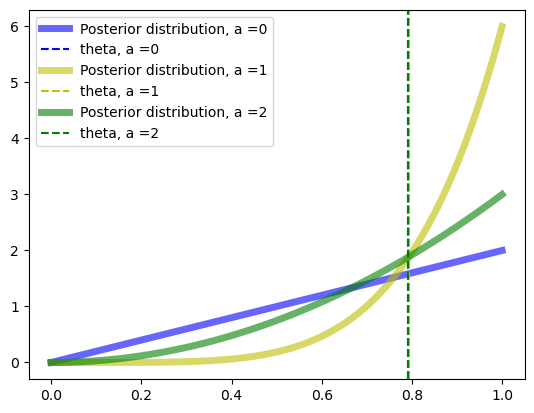

Posterior distribution after t =  8  updates
Y =  [1. 5. 2.] , N =  [1. 5. 2.]
alpha=[2. 6. 3.], beta = [1. 1. 1.]
theta = [0.79157928 0.79363821 0.79125707]
a =  1
Reward from this a = 1
['b', 'y', 'g']


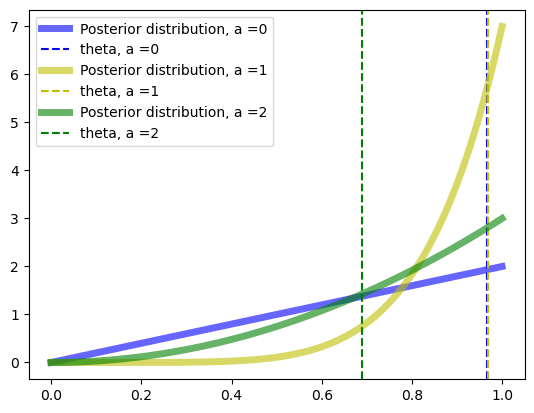

Posterior distribution after t =  9  updates
Y =  [1. 6. 2.] , N =  [1. 6. 2.]
alpha=[2. 7. 3.], beta = [1. 1. 1.]
theta = [0.96727238 0.96810873 0.68963079]
a =  1
Reward from this a = 1
['b', 'y', 'g']


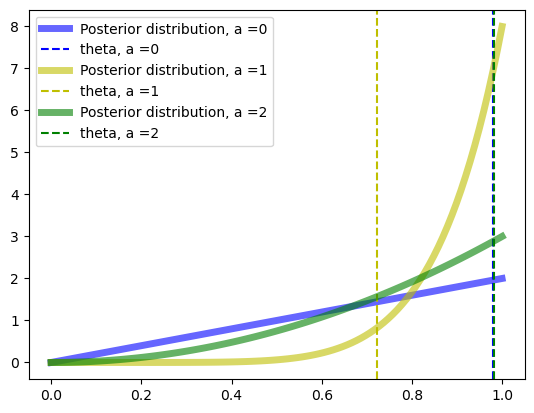

Posterior distribution after t =  10  updates
Y =  [1. 7. 2.] , N =  [1. 7. 2.]
alpha=[2. 8. 3.], beta = [1. 1. 1.]
theta = [0.97953868 0.72261097 0.98136662]
a =  2
Reward from this a = 1
['b', 'y', 'g']


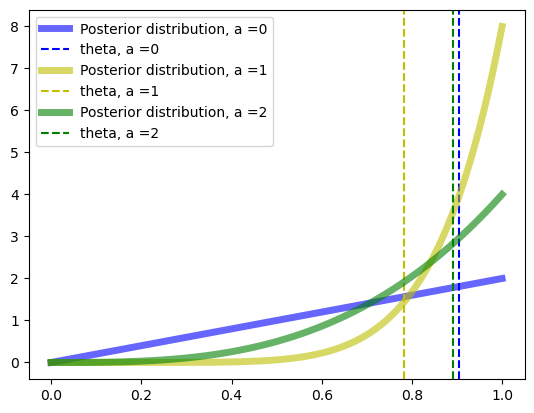

Posterior distribution after t =  11  updates
Y =  [1. 7. 3.] , N =  [1. 7. 3.]
alpha=[2. 8. 4.], beta = [1. 1. 1.]
theta = [0.90469242 0.78186583 0.89016263]
a =  0
Reward from this a = 1
['b', 'y', 'g']


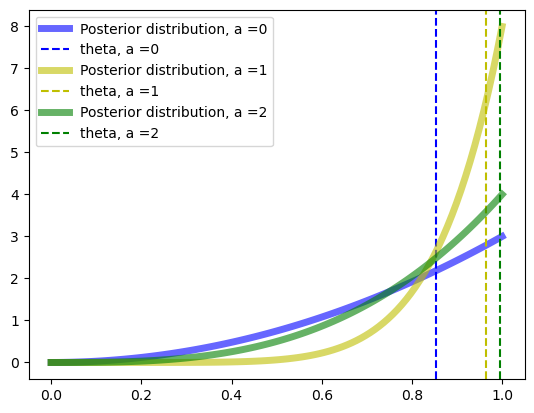

Posterior distribution after t =  12  updates
Y =  [2. 7. 3.] , N =  [2. 7. 3.]
alpha=[3. 8. 4.], beta = [1. 1. 1.]
theta = [0.85249968 0.96406919 0.99549174]
a =  2
Reward from this a = 1
['b', 'y', 'g']


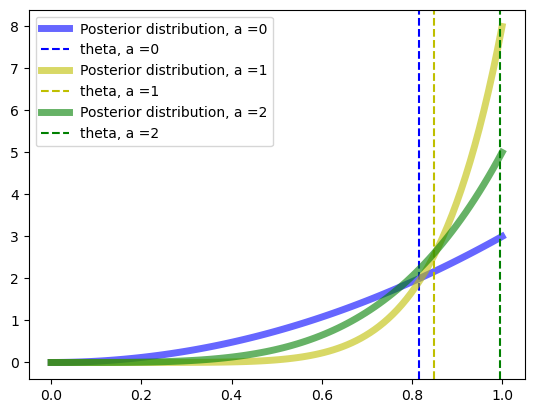

Posterior distribution after t =  13  updates
Y =  [2. 7. 4.] , N =  [2. 7. 4.]
alpha=[3. 8. 5.], beta = [1. 1. 1.]
theta = [0.81473674 0.84852133 0.99591841]
a =  2
Reward from this a = 0
['b', 'y', 'g']


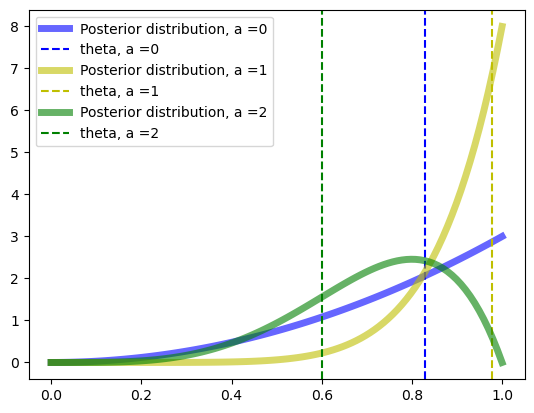

Posterior distribution after t =  14  updates
Y =  [2. 7. 4.] , N =  [2. 7. 5.]
alpha=[3. 8. 5.], beta = [1. 1. 2.]
theta = [0.83016441 0.97816776 0.60001867]
a =  1
Reward from this a = 1
['b', 'y', 'g']


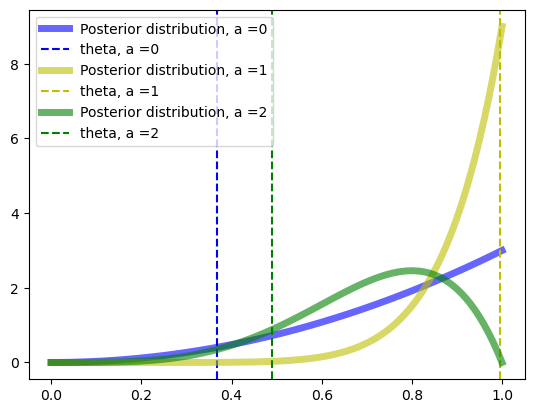

Posterior distribution after t =  15  updates
Y =  [2. 8. 4.] , N =  [2. 8. 5.]
alpha=[3. 9. 5.], beta = [1. 1. 2.]
theta = [0.36780872 0.99478166 0.49028352]
a =  1
Reward from this a = 1
['b', 'y', 'g']


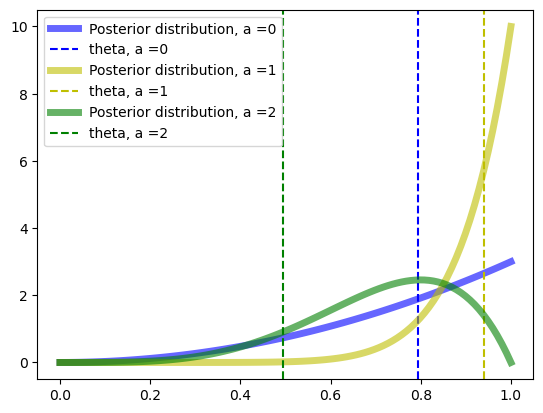

Posterior distribution after t =  16  updates
Y =  [2. 9. 4.] , N =  [2. 9. 5.]
alpha=[ 3. 10.  5.], beta = [1. 1. 2.]
theta = [0.79406261 0.941235   0.49359948]
a =  1
Reward from this a = 1
['b', 'y', 'g']


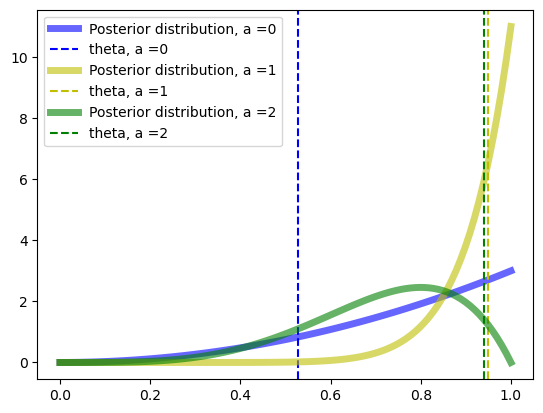

Posterior distribution after t =  17  updates
Y =  [ 2. 10.  4.] , N =  [ 2. 10.  5.]
alpha=[ 3. 11.  5.], beta = [1. 1. 2.]
theta = [0.52726392 0.9486004  0.94064164]
a =  1
Reward from this a = 1
['b', 'y', 'g']


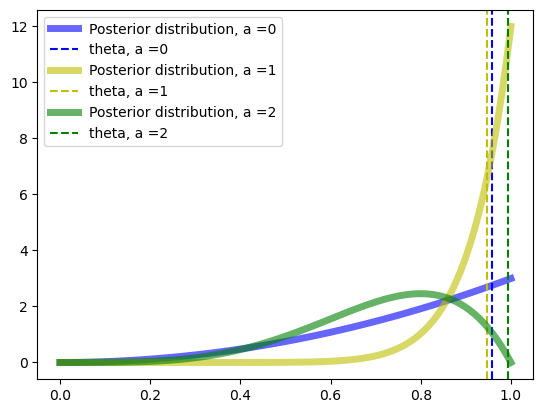

Posterior distribution after t =  18  updates
Y =  [ 2. 11.  4.] , N =  [ 2. 11.  5.]
alpha=[ 3. 12.  5.], beta = [1. 1. 2.]
theta = [0.95910566 0.94653931 0.99390378]
a =  2
Reward from this a = 1
['b', 'y', 'g']


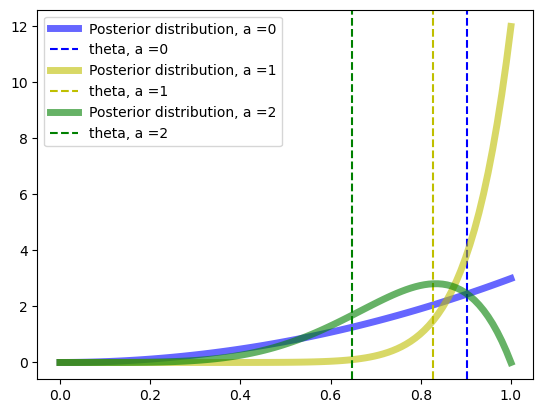

Posterior distribution after t =  19  updates
Y =  [ 2. 11.  5.] , N =  [ 2. 11.  6.]
alpha=[ 3. 12.  6.], beta = [1. 1. 2.]
theta = [0.90304825 0.82625992 0.64787925]
a =  0
Reward from this a = 0
['b', 'y', 'g']


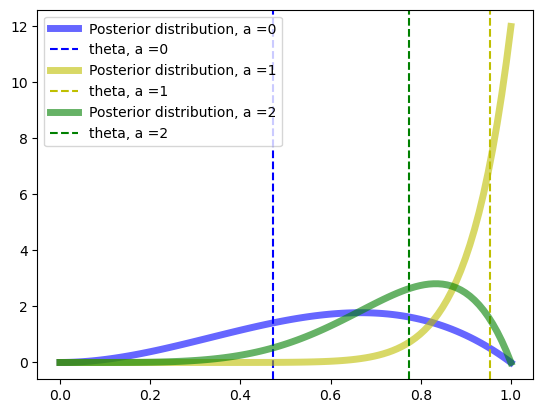

Posterior distribution after t =  20  updates
Y =  [ 2. 11.  5.] , N =  [ 3. 11.  6.]
alpha=[ 3. 12.  6.], beta = [2. 1. 2.]
theta = [0.47217132 0.9546591  0.7746238 ]
a =  1
Reward from this a = 0
['b', 'y', 'g']


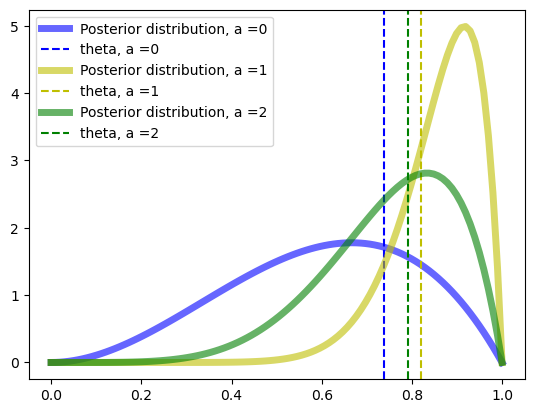

Posterior distribution after t =  21  updates
Y =  [ 2. 11.  5.] , N =  [ 3. 12.  6.]
alpha=[ 3. 12.  6.], beta = [2. 2. 2.]
theta = [0.73829455 0.82069926 0.79151783]
a =  1
Reward from this a = 0
['b', 'y', 'g']


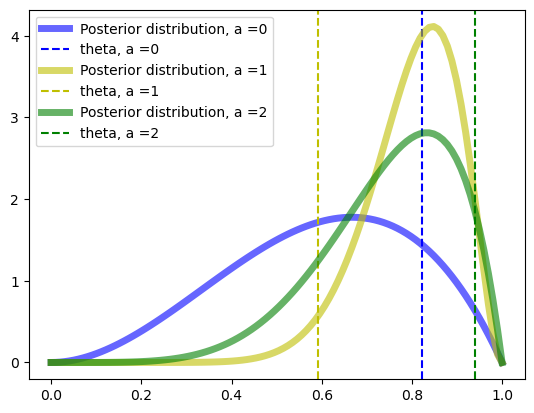

Posterior distribution after t =  22  updates
Y =  [ 2. 11.  5.] , N =  [ 3. 13.  6.]
alpha=[ 3. 12.  6.], beta = [2. 3. 2.]
theta = [0.82211956 0.59127511 0.94066698]
a =  2
Reward from this a = 1
['b', 'y', 'g']


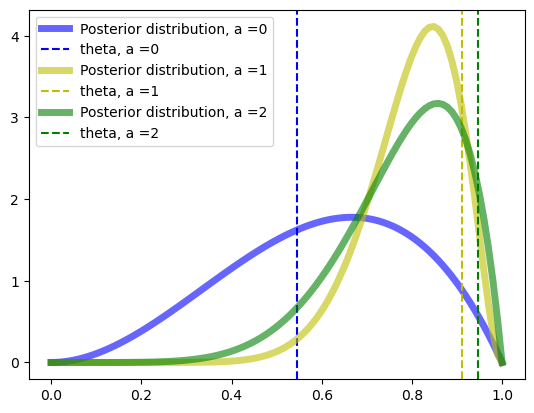

Posterior distribution after t =  23  updates
Y =  [ 2. 11.  6.] , N =  [ 3. 13.  7.]
alpha=[ 3. 12.  7.], beta = [2. 3. 2.]
theta = [0.54502444 0.91051134 0.94611728]
a =  2
Reward from this a = 1
['b', 'y', 'g']


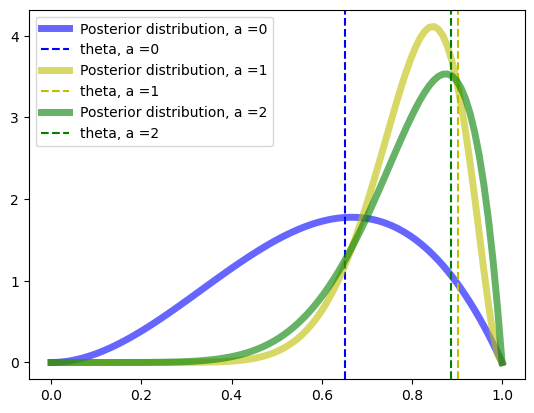

Posterior distribution after t =  24  updates
Y =  [ 2. 11.  7.] , N =  [ 3. 13.  8.]
alpha=[ 3. 12.  8.], beta = [2. 3. 2.]
theta = [0.65183438 0.90268344 0.8867728 ]
a =  1
Reward from this a = 0
['b', 'y', 'g']


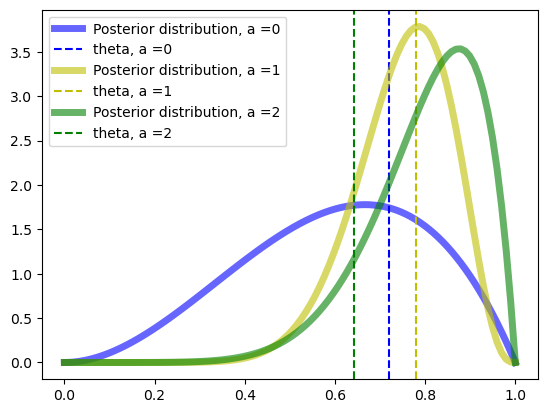

Posterior distribution after t =  25  updates
Y =  [ 2. 11.  7.] , N =  [ 3. 14.  8.]
alpha=[ 3. 12.  8.], beta = [2. 4. 2.]
theta = [0.71916969 0.77950352 0.64171972]
a =  1
Reward from this a = 0
['b', 'y', 'g']


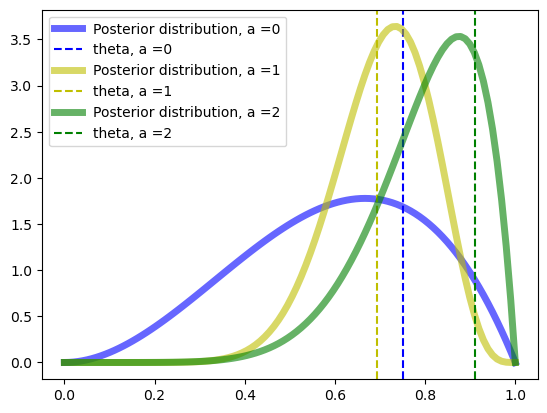

Posterior distribution after t =  26  updates
Y =  [ 2. 11.  7.] , N =  [ 3. 15.  8.]
alpha=[ 3. 12.  8.], beta = [2. 5. 2.]
theta = [0.7502529  0.69343576 0.91072636]
a =  2
Reward from this a = 1
['b', 'y', 'g']


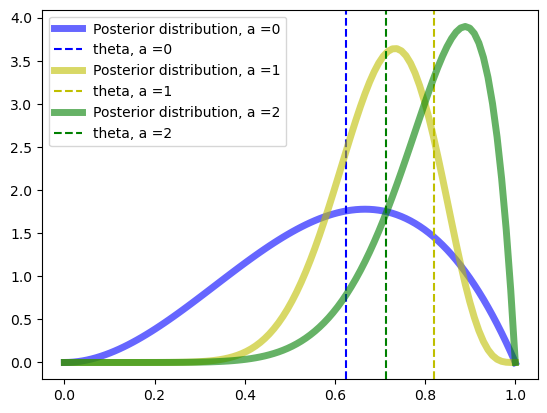

Posterior distribution after t =  27  updates
Y =  [ 2. 11.  8.] , N =  [ 3. 15.  9.]
alpha=[ 3. 12.  9.], beta = [2. 5. 2.]
theta = [0.62403847 0.81864661 0.71316038]
a =  1
Reward from this a = 1
['b', 'y', 'g']


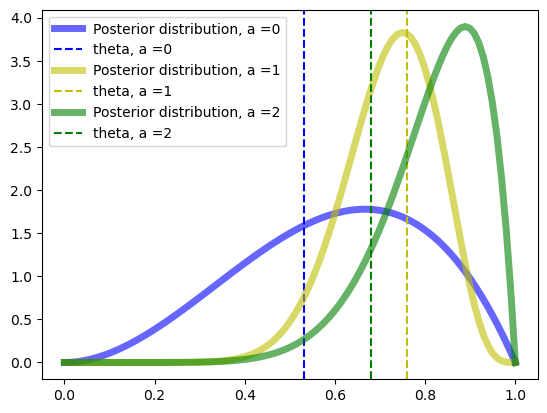

Posterior distribution after t =  28  updates
Y =  [ 2. 12.  8.] , N =  [ 3. 16.  9.]
alpha=[ 3. 13.  9.], beta = [2. 5. 2.]
theta = [0.53221368 0.75947393 0.67897024]
a =  1
Reward from this a = 1
['b', 'y', 'g']


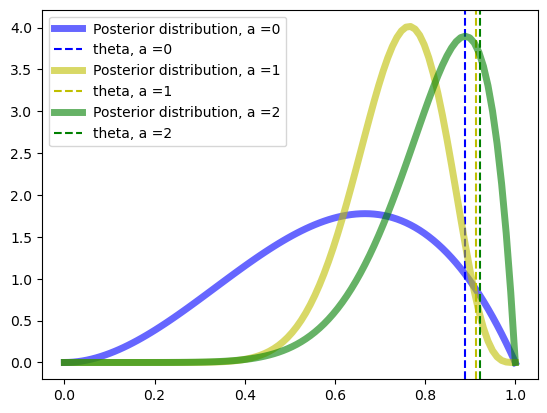

Posterior distribution after t =  29  updates
Y =  [ 2. 13.  8.] , N =  [ 3. 17.  9.]
alpha=[ 3. 14.  9.], beta = [2. 5. 2.]
theta = [0.88857027 0.91198153 0.92124402]
a =  2
Reward from this a = 1
['b', 'y', 'g']


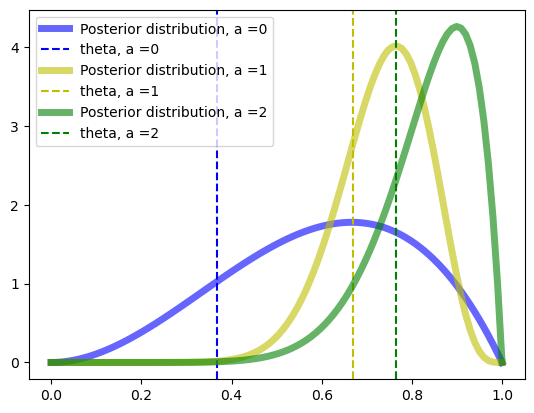

Posterior distribution after t =  30  updates
Y =  [ 2. 13.  9.] , N =  [ 3. 17. 10.]
alpha=[ 3. 14. 10.], beta = [2. 5. 2.]
theta = [0.36803652 0.67015502 0.76413968]
a =  2
Reward from this a = 1
['b', 'y', 'g']


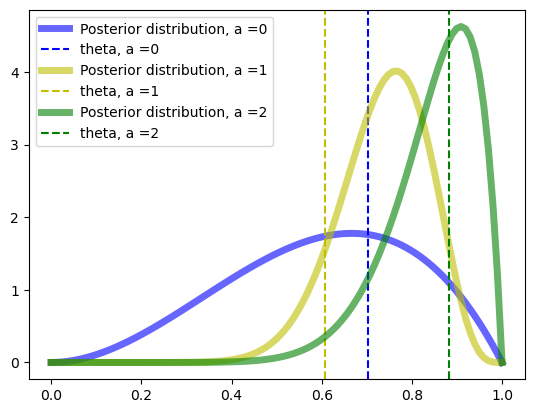

Posterior distribution after t =  31  updates
Y =  [ 2. 13. 10.] , N =  [ 3. 17. 11.]
alpha=[ 3. 14. 11.], beta = [2. 5. 2.]
theta = [0.70310628 0.60709612 0.88334264]
a =  2
Reward from this a = 1
['b', 'y', 'g']


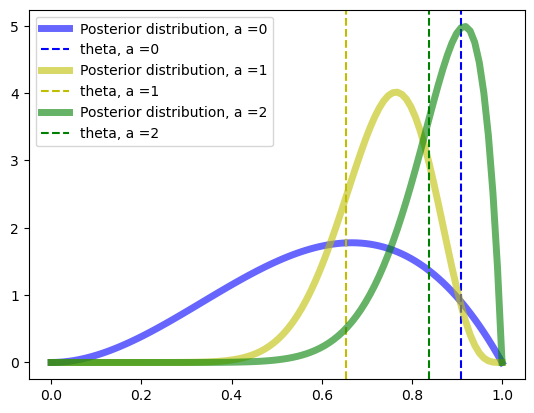

Posterior distribution after t =  32  updates
Y =  [ 2. 13. 11.] , N =  [ 3. 17. 12.]
alpha=[ 3. 14. 12.], beta = [2. 5. 2.]
theta = [0.90953458 0.65374092 0.83826506]
a =  0
Reward from this a = 0
['b', 'y', 'g']


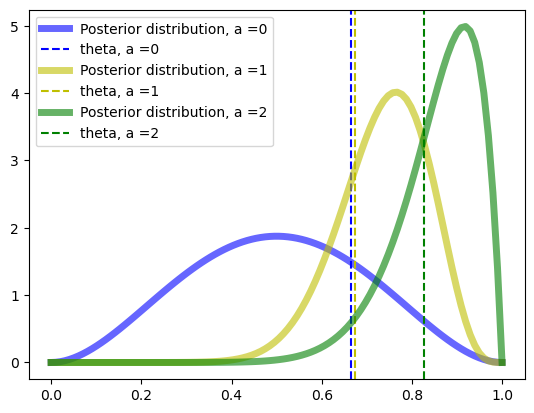

Posterior distribution after t =  33  updates
Y =  [ 2. 13. 11.] , N =  [ 4. 17. 12.]
alpha=[ 3. 14. 12.], beta = [3. 5. 2.]
theta = [0.6657578  0.6741368  0.82642426]
a =  2
Reward from this a = 1
['b', 'y', 'g']


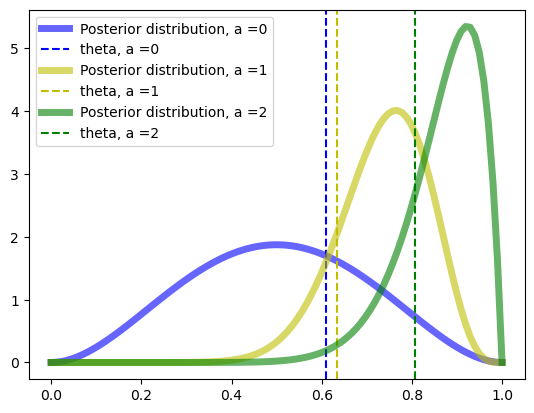

Posterior distribution after t =  34  updates
Y =  [ 2. 13. 12.] , N =  [ 4. 17. 13.]
alpha=[ 3. 14. 13.], beta = [3. 5. 2.]
theta = [0.61033459 0.63306622 0.80786401]
a =  2
Reward from this a = 1
['b', 'y', 'g']


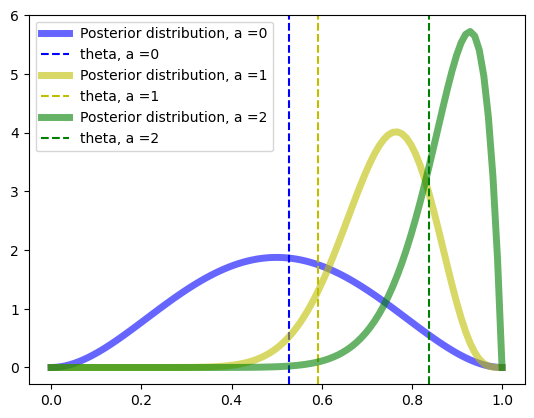

Posterior distribution after t =  35  updates
Y =  [ 2. 13. 13.] , N =  [ 4. 17. 14.]
alpha=[ 3. 14. 14.], beta = [3. 5. 2.]
theta = [0.52770398 0.59165486 0.83863596]
a =  2
Reward from this a = 1
['b', 'y', 'g']


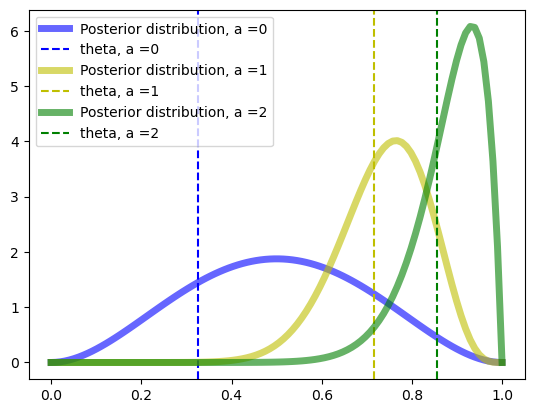

Posterior distribution after t =  36  updates
Y =  [ 2. 13. 14.] , N =  [ 4. 17. 15.]
alpha=[ 3. 14. 15.], beta = [3. 5. 2.]
theta = [0.32490469 0.71530192 0.85673962]
a =  2
Reward from this a = 1
['b', 'y', 'g']


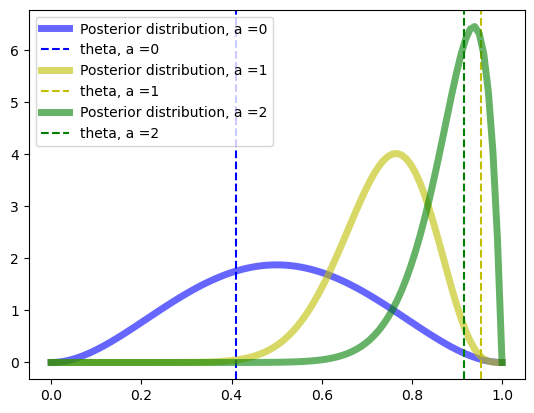

Posterior distribution after t =  37  updates
Y =  [ 2. 13. 15.] , N =  [ 4. 17. 16.]
alpha=[ 3. 14. 16.], beta = [3. 5. 2.]
theta = [0.41075307 0.95223859 0.916528  ]
a =  1
Reward from this a = 1
['b', 'y', 'g']


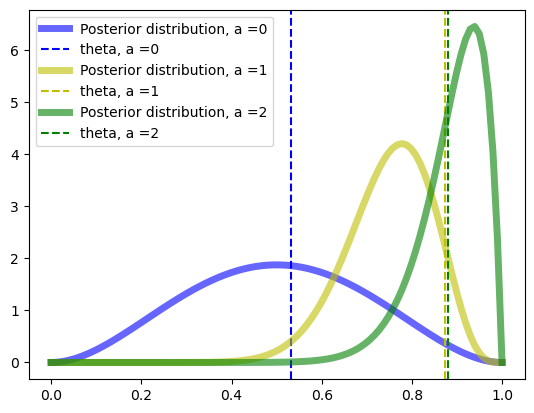

Posterior distribution after t =  38  updates
Y =  [ 2. 14. 15.] , N =  [ 4. 18. 16.]
alpha=[ 3. 15. 16.], beta = [3. 5. 2.]
theta = [0.53092254 0.87408495 0.87945459]
a =  2
Reward from this a = 1
['b', 'y', 'g']


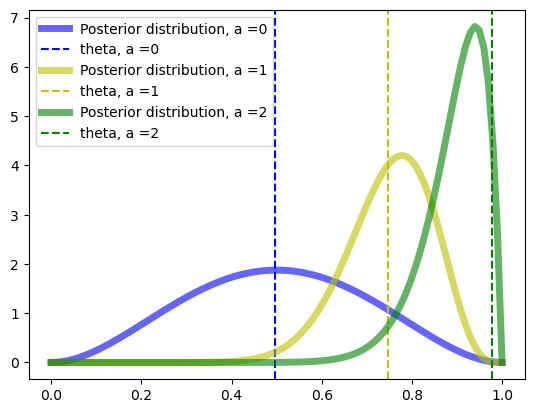

Posterior distribution after t =  39  updates
Y =  [ 2. 14. 16.] , N =  [ 4. 18. 17.]
alpha=[ 3. 15. 17.], beta = [3. 5. 2.]
theta = [0.49582682 0.74798301 0.97817804]
a =  2
Reward from this a = 1
['b', 'y', 'g']


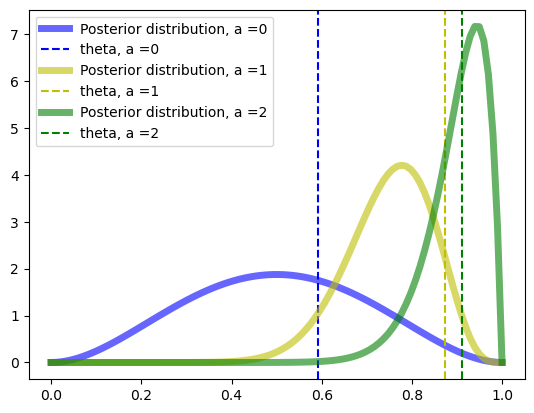

Posterior distribution after t =  40  updates
Y =  [ 2. 14. 17.] , N =  [ 4. 18. 18.]
alpha=[ 3. 15. 18.], beta = [3. 5. 2.]
theta = [0.59255958 0.87377054 0.91128704]
a =  2
Reward from this a = 1
['b', 'y', 'g']


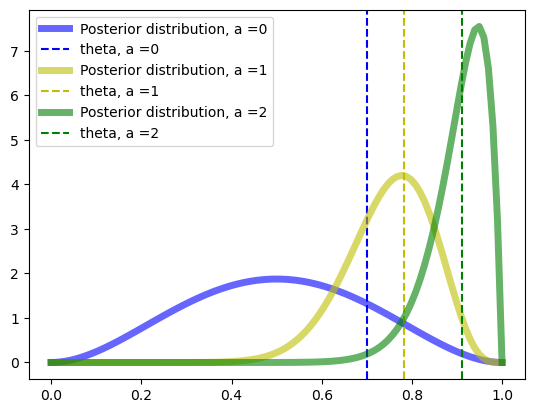

Posterior distribution after t =  41  updates
Y =  [ 2. 14. 18.] , N =  [ 4. 18. 19.]
alpha=[ 3. 15. 19.], beta = [3. 5. 2.]
theta = [0.69965371 0.78265873 0.91198035]
a =  2
Reward from this a = 1
['b', 'y', 'g']


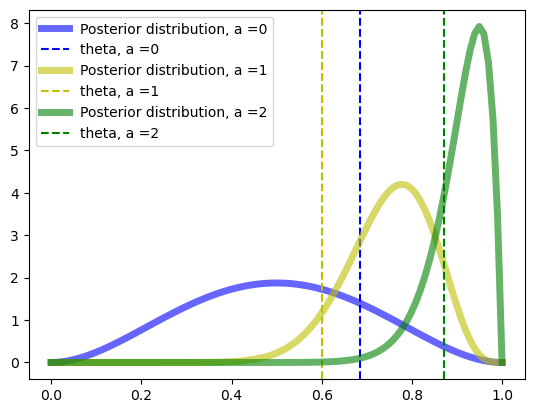

Posterior distribution after t =  42  updates
Y =  [ 2. 14. 19.] , N =  [ 4. 18. 20.]
alpha=[ 3. 15. 20.], beta = [3. 5. 2.]
theta = [0.68438082 0.59988614 0.87121878]
a =  2
Reward from this a = 1
['b', 'y', 'g']


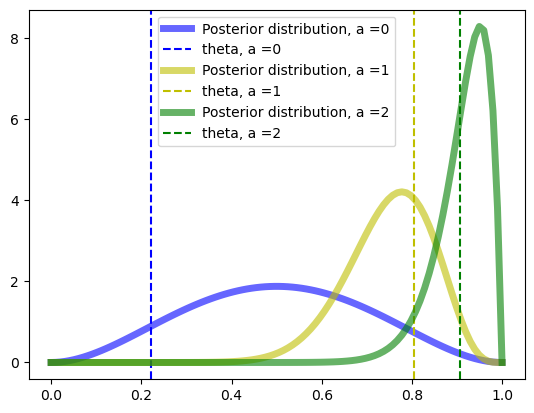

Posterior distribution after t =  43  updates
Y =  [ 2. 14. 20.] , N =  [ 4. 18. 21.]
alpha=[ 3. 15. 21.], beta = [3. 5. 2.]
theta = [0.22131242 0.80525006 0.90650874]
a =  2
Reward from this a = 1
['b', 'y', 'g']


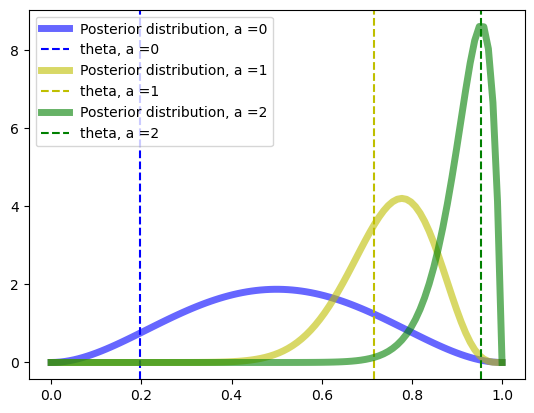

Posterior distribution after t =  44  updates
Y =  [ 2. 14. 21.] , N =  [ 4. 18. 22.]
alpha=[ 3. 15. 22.], beta = [3. 5. 2.]
theta = [0.19783704 0.71623036 0.95246337]
a =  2
Reward from this a = 1
['b', 'y', 'g']


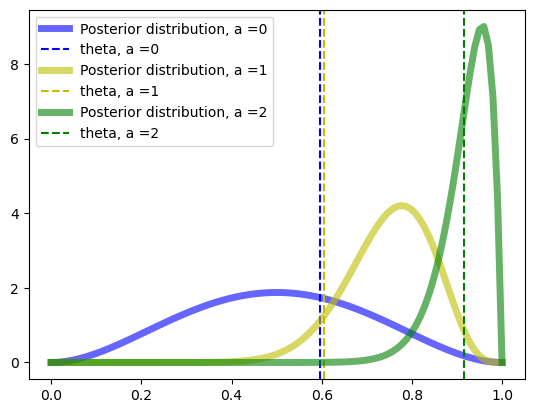

Posterior distribution after t =  45  updates
Y =  [ 2. 14. 22.] , N =  [ 4. 18. 23.]
alpha=[ 3. 15. 23.], beta = [3. 5. 2.]
theta = [0.59535428 0.60443944 0.91549134]
a =  2
Reward from this a = 0
['b', 'y', 'g']


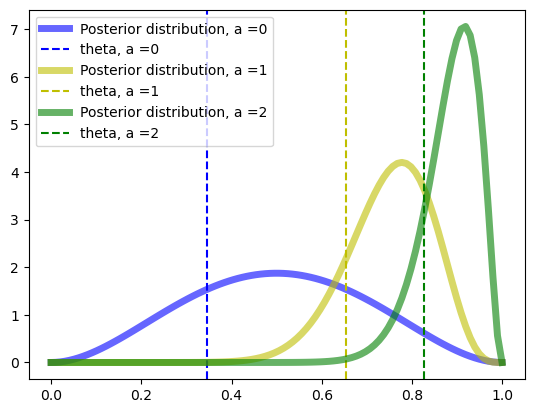

Posterior distribution after t =  46  updates
Y =  [ 2. 14. 22.] , N =  [ 4. 18. 24.]
alpha=[ 3. 15. 23.], beta = [3. 5. 3.]
theta = [0.34656822 0.65405921 0.82751251]
a =  2
Reward from this a = 1
['b', 'y', 'g']


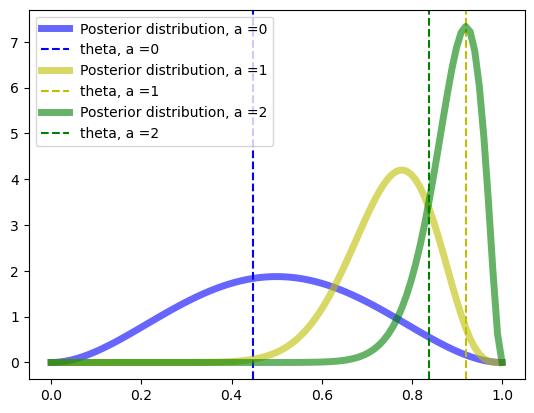

Posterior distribution after t =  47  updates
Y =  [ 2. 14. 23.] , N =  [ 4. 18. 25.]
alpha=[ 3. 15. 24.], beta = [3. 5. 3.]
theta = [0.44713707 0.92018566 0.83729644]
a =  1
Reward from this a = 0
['b', 'y', 'g']


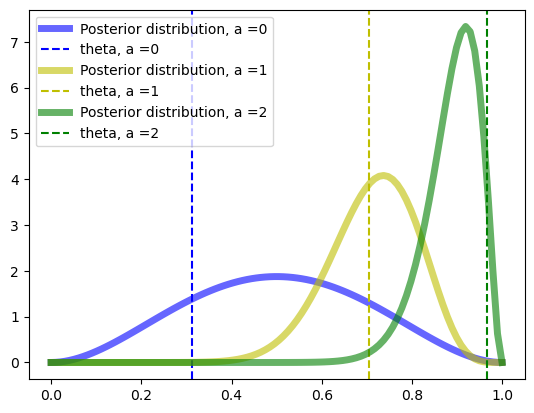

Posterior distribution after t =  48  updates
Y =  [ 2. 14. 23.] , N =  [ 4. 19. 25.]
alpha=[ 3. 15. 24.], beta = [3. 6. 3.]
theta = [0.31162499 0.70588876 0.96729166]
a =  2
Reward from this a = 1
['b', 'y', 'g']


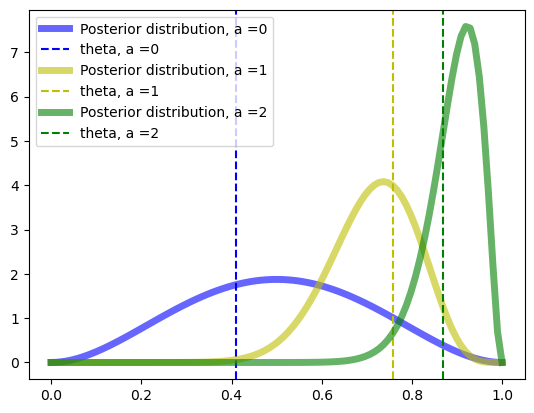

Posterior distribution after t =  49  updates
Y =  [ 2. 14. 24.] , N =  [ 4. 19. 26.]
alpha=[ 3. 15. 25.], beta = [3. 6. 3.]
theta = [0.41003315 0.7592409  0.8686752 ]
a =  2
Reward from this a = 1
['b', 'y', 'g']


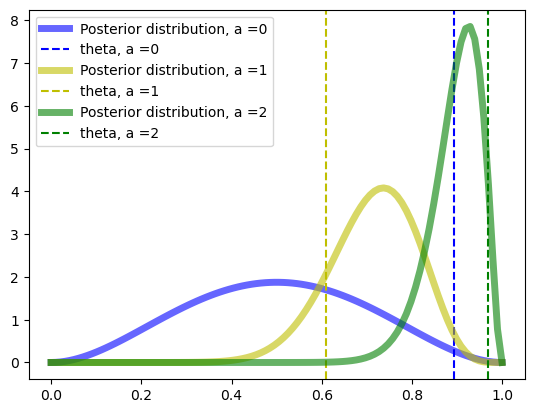

Posterior distribution after t =  50  updates
Y =  [ 2. 14. 25.] , N =  [ 4. 19. 27.]
alpha=[ 3. 15. 26.], beta = [3. 6. 3.]
theta = [0.89346385 0.6088424  0.9683147 ]
a =  2
Reward from this a = 1
['b', 'y', 'g']


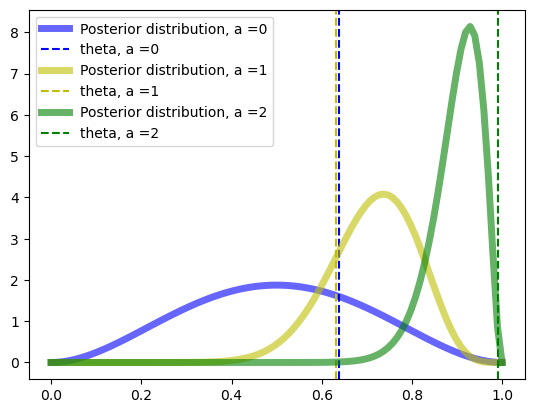

Posterior distribution after t =  51  updates
Y =  [ 2. 14. 26.] , N =  [ 4. 19. 28.]
alpha=[ 3. 15. 27.], beta = [3. 6. 3.]
theta = [0.63807442 0.63092018 0.99050904]
a =  2
Reward from this a = 1


In [12]:
np.random.seed(50)
alpha = np.ones(K)
beta = np.ones(K)

Y = np.zeros(K)
N = np.zeros(K)

t = 0

action_colors = ["b", "y", "g"]


# These next commands plot the current Beta distribution, which is 
# our prior distribution on p.
x = np.linspace(0,1,100)
theta = np.random.beta(alpha,beta)
a = np.argmax(theta)
for a in range(K):
    pdf = stats.beta.pdf(x, alpha[a],beta[a])
    plt.plot(x, pdf, '-', lw=5, alpha=0.6, color = action_colors[a], label='Prior distribution, a =' + str(a))
    plt.axvline(x = theta[a], color = action_colors[a], linestyle = 'dashed', label = 'theta, a =' + str(a))
plt.legend()
plt.ion()
plt.show()
plt.pause(0.001)
print("(Prior distributions)")
print("t = ", t )
print("Y = ", Y, ", N = ", N)
print('alpha='+str(alpha)+', beta = '+str(beta))
print("theta =", theta)
print("a = ", np.argmax(theta))
a = np.argmax(theta)
reward = generate_reward(a)
print("Reward from this a =", reward)
# continue_string = input("Continue? (y/n)")

while (True):
    t += 1
    
    Y[a] += reward
    N[a] += 1

    alpha = 1 + Y
    beta = 1 + N - Y
      
    theta = np.random.beta(alpha,beta)
    a = np.argmax(theta)
    reward = generate_reward(a)
    x = np.linspace(0,1,100)
    print(action_colors)
    
    for a2 in range(K):
        pdf = stats.beta.pdf(x, alpha[a2],beta[a2])
        plt.plot(x, pdf, '-', lw=5, alpha=0.6, color = action_colors[a2], label='Posterior distribution, a =' + str(a2))
        plt.axvline(x = theta[a2], color = action_colors[a2], linestyle = 'dashed', label = 'theta, a =' + str(a2))
    plt.legend()
    plt.ion()
    plt.show()
    plt.pause(0.001)
    print("Posterior distribution after t = ", t, 
          " updates")
    print("Y = ", Y, ", N = ", N)
    print('alpha='+str(alpha)+', beta = '+str(beta))
    print("theta =", theta)
    print("a = ", np.argmax(theta))
    print("Reward from this a =", reward)
#     continue_string = input("Continue? (y/n)")
    if (t > 50):
        break
        
    





## Method 5: Thompson Sampling

The method of Thompson sampling provides an elegant solution to how to select an action that takes into account the uncertainty in our current estimates of each action's conversion rate. The idea is as follows. The reward $X_{t,a}$ at each period follows a Bernoulli distribution:

$$ X_{t,a} \sim \text{Bernoulli}(p_a). $$

Before we take any actions, let us assume a prior distribution on each $p_a$. For the Bernoulli parameter $p_a$, the natural prior distribution is a Beta distribution:

$$ p_a \sim \text{Beta}(\alpha_a, \beta_a)$$

The two parameters $\alpha_a$, $\beta_a$ are both initialized to 1. Thus, initially we are assuming that $p_a \sim \text{Beta}(1,1)$. 

At each period, we then make decisions as follows:
- For each $a$, set $\alpha_a \gets 1 + Y_{t,a}$, $\beta_a \gets 1 + N_a - S_a$, where $S_a$ is the number of successes (reward was $X_{t,a} = 1$) from taking action $a$, and $N_a$ is the total number of times action $a$ was taken. (Note that $N_a - S_a$ counts the number of "failures" (reward was $X_{t,a} = 0$). 
- For each $a$, draw a number $\tilde{p}_a \sim \text{Beta}(\alpha_a, \beta_a)$.
- Select $a^* = \arg \max_{a = 1, \dots, n} \tilde{p}_a$. (In other words, take the action whose randomly generated number $\tilde{p}_a$ is highest.)

The number $\tilde{p}_a$ is a sample from the posterior distribution of the success probability of each action; we are then taking the action whose sample was highest. (For this reason Thompson sampling is also known as posterior sampling.)

In [16]:
# Define the Thompson sampling policy function:
p = [0.7, 0.89, 0.90]

def policy_TS(t, Y, N):
    alpha = 1 + Y
    beta = 1 + N - Y 
    theta = np.random.beta(alpha, beta)
    a = np.argmax(theta)
    return a 

# Run the simulation 
np.random.seed(200)
nSims = 1000
cumulative_reward = np.zeros( (nSims, T) )
action_history = np.zeros( (nSims, T))
for s in range(nSims):
    Y = np.zeros(K)
    N = np.zeros(K)
    for t in range(T):
        a = policy_TS(t, Y, N)
        reward = generate_reward(a)
        Y[a] += reward
        N[a] += 1
        cumulative_reward[s,t] = sum(Y)
        action_history[s,t] = a

action_history_TS = action_history.copy()
mean_cumulative_reward_TS = cumulative_reward.mean(axis = 0)
print(len(mean_cumulative_reward_TS))
print(mean_cumulative_reward_TS[-1])
print(mean_cumulative_reward_TS[-1] / T)

2000
1788.13
0.8940650000000001


Our total conversion count is 1787.278 (averaged over 1000 simulations), and the per-period conversion rate is 0.894. Both of these metrics are higher than for greedy, ETC, explore-then-greedy and $\epsilon$-greedy. Most interestingly, observe how the probability of each action being selected behaves under this approach:

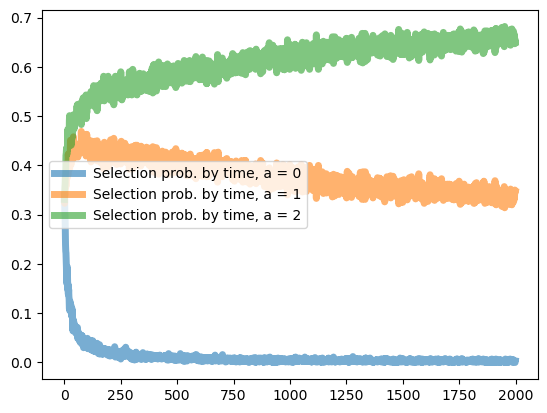

In [17]:
# Plot the empirical probability of each design being selected.
for a in range(K):
    action_history_eq_a = action_history_TS == a 
    a_prob_by_time = action_history_eq_a.mean(axis = 0)

    plt.plot(range(T), a_prob_by_time, '-', lw=5, alpha=0.6, label='Selection prob. by time, a = ' + str(a))
plt.legend()

What we find is that the probability of the optimal action being selected converges to 1, while the probabilities of the other actions decay to zero, exactly as one would hope from a "good" algorithm. 

## Comparing the algorithms

In bandit models, one approach for comparing the performance of different algorithms is to compute what is called cumulative regret. Cumulative regret measures the difference between the expected optimal cumulative reward we would get if we always took the best action, and the expected cumulative reward obtained from our policy. 

For this problem, the optimal action's reward in a period is exactly $p^* = \max\{0.7, 0.8, 0.9\} = 0.9$, so the expected optimal cumulative reward by period $t$ can be calculated as 
$$ t \times p^* = 0.9 t.$$

With this in mind, the code below calculates this cumulative regret, as a function of $t$:

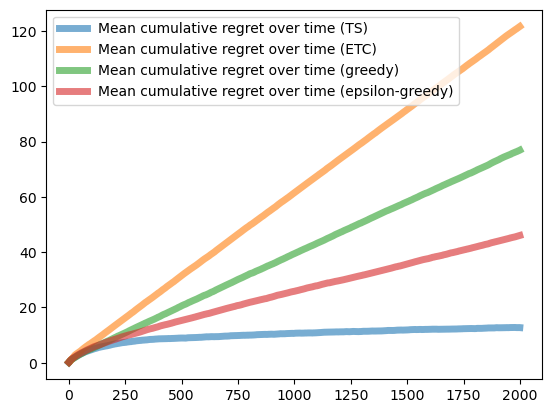

In [15]:
plt.plot(range(T), max(p)*range(1,T+1)-mean_cumulative_reward_TS , '-', lw=5, alpha=0.6, label='Mean cumulative regret over time (TS)')
# plt.plot(range(T), max(p)*range(1,T+1)-mean_cumulative_reward_UCB , '-', lw=5, alpha=0.6, label='Mean cumulative regret over time (UCB)')
plt.plot(range(T), max(p)*range(1,T+1)-mean_cumulative_reward_ETC , '-', lw=5, alpha=0.6, label='Mean cumulative regret over time (ETC)')
plt.plot(range(T), max(p)*range(1,T+1)-mean_cumulative_reward_greedy , '-', lw=5, alpha=0.6, label='Mean cumulative regret over time (greedy)')
plt.plot(range(T), max(p)*range(1,T+1)-mean_cumulative_reward_epsilon_greedy , '-', lw=5, alpha=0.6, label='Mean cumulative regret over time (epsilon-greedy)')



plt.legend()

Consistently with the cumulative reward metrics we calculated, Thompson sampling has the lowest cumulative regret, followed by $\epsilon$-greedy, followed by greedy. What is perhaps not easy to discern from this figure is that there is a qualitative difference in shape. For both greedy and $\epsilon$-greedy, the cumulative regret asymptotically behaves like a linear function, whereas for Thompson sampling, the cumulative regret will roughly scale like $\sqrt{ T \log T }$, which grows slower than any linear function. It is generally undesirable to have cumulative regret that is linear, because it means that as time goes on, we are always deviating with some constant frequency from the optimal action. 